<a href="https://colab.research.google.com/github/fiapdatanalytics/tech-challenge4/blob/main/tech_challenge_4_treinamento_modelo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas**

In [109]:
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# **Funções**

## **Plotar matriz de confusão**

In [110]:
def plotar_matriz_confusao(y_real, y_previsto, titulo, cmap='Greens'):
    """
    Plota uma matriz de confusão customizada usando seaborn.
    """
    cm = confusion_matrix(y_real, y_previsto)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.title(titulo, fontsize=16)
    plt.xlabel('Previsto', fontsize=12)
    plt.ylabel('Verdadeiro', fontsize=12)
    plt.show()

## **Extrair Métricas Completas**

In [111]:
def extrair_metricas_completas(y_real, y_previsto):
    """
    Calcula acurácia e o relatório de classificação,
    retornando um dicionário formatado com MultiIndex.
    """

    relatorio_dict = classification_report(y_real, y_previsto, output_dict=True)
    acc = accuracy_score(y_real, y_previsto)

    metricas_simples = {}


    metricas_simples[('Geral', 'Acurácia')] = acc


    classes_encontradas = [str(i) for i in range(7)]
    for classe_str in classes_encontradas:
        if classe_str in relatorio_dict:
            metricas_simples[(f'Classe {classe_str}', 'precision')] = relatorio_dict[classe_str]['precision']
            metricas_simples[(f'Classe {classe_str}', 'recall')] = relatorio_dict[classe_str]['recall']
            metricas_simples[(f'Classe {classe_str}', 'f1-score')] = relatorio_dict[classe_str]['f1-score']
        else:
            metricas_simples[(f'Classe {classe_str}', 'precision')] = 0.0
            metricas_simples[(f'Classe {classe_str}', 'recall')] = 0.0
            metricas_simples[(f'Classe {classe_str}', 'f1-score')] = 0.0


    metricas_simples[('Médias', 'Macro Avg (f1)')] = relatorio_dict['macro avg']['f1-score']
    metricas_simples[('Médias', 'Weighted Avg (f1)')] = relatorio_dict['weighted avg']['f1-score']

    return metricas_simples

## **Tablela Comparativa**

In [112]:
def exibir_tabela_comparativa(metricas_dict):
    """
    Exibe a tabela comparativa de desempenho dos modelos a partir de um dicionário de métricas.

    Args:
        metricas_dict (dict): Dicionário onde as chaves são os nomes dos modelos
                              e os valores são os dicionários de métricas retornados por extrair_metricas_completas.
    """
    print("\n--- Tabela Comparativa de Desempenho Completa ---")


    df_resultados_completo = pd.DataFrame(metricas_dict)

    pd.set_option('display.float_format', '{:.4f}'.format)

    print("Visualização 1: Modelos nas Colunas")
    display(df_resultados_completo)

    print("\nVisualização 2: Modelos nas Linhas (Transposto)")

    display(df_resultados_completo.T.sort_values(by=('Médias', 'Macro Avg (f1)'), ascending=False))



## **Plotar Importância de variaveis**

In [113]:
def plotar_importancia_variaveis(modelo, nome_variavel, titulo, num_variaveis=15):
    """
    Plota as variaveis mais importantes de um modelo baseado em árvore.
    """

    if not hasattr(modelo, 'feature_importances_'):
        print(f"Erro: O modelo fornecido ({type(modelo).__name__}) não possui o atributo 'feature_importances_'. Não é possível plotar a importância das variáveis.")
        return

    importancia = modelo.feature_importances_

    df_importancia = pd.DataFrame({
        'variavel': nome_variavel,
        'importancia': importancia
    }).sort_values(by='importancia', ascending=False).head(num_variaveis)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importancia', y='variavel', data=df_importancia)
    plt.title(titulo, fontsize=16)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Variável', fontsize=12)
    plt.show()

try:
    print("Funções auxiliares (incluindo plotar_importancia_variaveis) prontas.")
except Exception as e:
    print(f"Ocorreu um erro ao definir as funções auxiliares: {e}")

Funções auxiliares (incluindo plotar_importancia_variaveis) prontas.


# **Primeiro bloco de treinamento**

**Modelos testados:**

Modelos de Árvore (Ensemble/Bagging): RandomForest

Modelos de Boosting (Ensemble/Boosting): XGBoost

Modelos de Kernel (Distância): SVM

Modelos Lineares: LogisticRegression


**Técnica de Análise Utilizada para Cada Modelo:**

Para cada modelo (`RandomForest`, `XGBoost`, `SVM`, `LogisticRegression`), a técnica de análise seguiu um padrão consistente:

1.  **Treinamento do Modelo:** O modelo foi treinado utilizando o conjunto de dados de treino (`X_treino`, `y_treino`). Para `RandomForest` e `XGBoost`, versões "baseline" e otimizadas via `GridSearchCV` foram testadas. Para `SVM` e `LogisticRegression`, apenas versões "baseline" com parâmetros razoáveis foram apresentadas.
2.  **Previsão:** O modelo treinado foi utilizado para fazer previsões no conjunto de dados de teste (`X_teste`).
3.  **Avaliação Visual:** O desempenho do modelo foi avaliado visualmente através:
    *   Do **Relatório de Classificação**: Apresentando métricas como Precisão, Recall e F1-score para cada classe e médias (macro e weighted averages).
    *   Da **Matriz de Confusão**: Visualizando os acertos e erros por classe (verdadeiros positivos, falsos positivos, verdadeiros negativos, falsos negativos).
    *   **(Para modelos baseados em árvore - RF e XGBoost)** Do gráfico de **Importância de variáveis**: Mostrando quais características do dataset foram mais relevantes para o modelo tomar suas decisões.
4.  **Captura Programática das Métricas:** As métricas de desempenho completas foram extraídas programaticamente e armazenadas em um dicionário (`metricas_todos_modelos`) para comparação posterior.
5.  **Comparação:** Uma tabela comparativa agregando as métricas de todos os modelos foi gerada e exibida, permitindo uma análise lado a lado do desempenho.

## **Separação dos dados**

**Tamanho amostra de treino:** 80%

**Tamanho amostra de teste:** 20%

-  O parâmetro `random_state=42` garanti que a divisão seja sempre a mesma em execuções diferentes (reprodutibilidade)

- Utilizado o parametro `stratify=y` para manter as proporções de classes



In [114]:
print("Carregando e preparando os dados...")
try:
    df = pd.read_csv('https://raw.githubusercontent.com/bernardo-seg/tech-challenge-obesidade/refs/heads/main/dados/obesidade_processado.csv')
except FileNotFoundError:
    print("Erro: 'obesidade_processado.csv' não encontrado. Faça o upload.")
    raise

coluna_alvo = 'classificacao_peso_corporal_rcod'
X = df.drop(columns=[coluna_alvo])
y = df[coluna_alvo].astype(int)

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Dados prontos: {len(X_treino)} amostras de treino, {len(X_teste)} amostras de teste.")

metricas_todos_modelos = {}

Carregando e preparando os dados...
Dados prontos: 1688 amostras de treino, 423 amostras de teste.


### **stadartScaler na coluna `idade`**

In [115]:
scaler = StandardScaler()

scaler.fit(X_treino[['idade']])

X_treino['idade'] = scaler.transform(X_treino[['idade']])
X_teste['idade'] = scaler.transform(X_teste[['idade']])

print("Coluna 'idade' escalada corretamente após a divisão.")


Coluna 'idade' escalada corretamente após a divisão.


## **Treinamento Random Forest**

### **Treinamento modelo base (RF)**


--- Treinando Modelo 1: Linha de Base (Random Forest) ---

Relatório de Classificação (Linha de base):
              precision    recall  f1-score   support

           0       0.80      0.87      0.84        70
           1       0.88      0.95      0.91        60
           2       0.98      1.00      0.99        65
           3       0.72      0.87      0.79        54
           4       0.64      0.66      0.65        58
           5       0.89      0.67      0.76        58
           6       0.83      0.69      0.75        58

    accuracy                           0.82       423
   macro avg       0.82      0.82      0.81       423
weighted avg       0.82      0.82      0.82       423



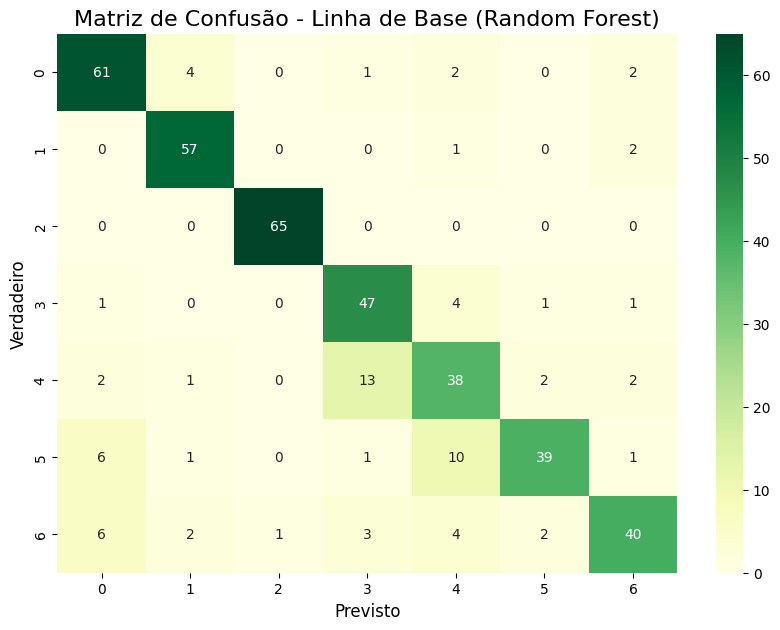

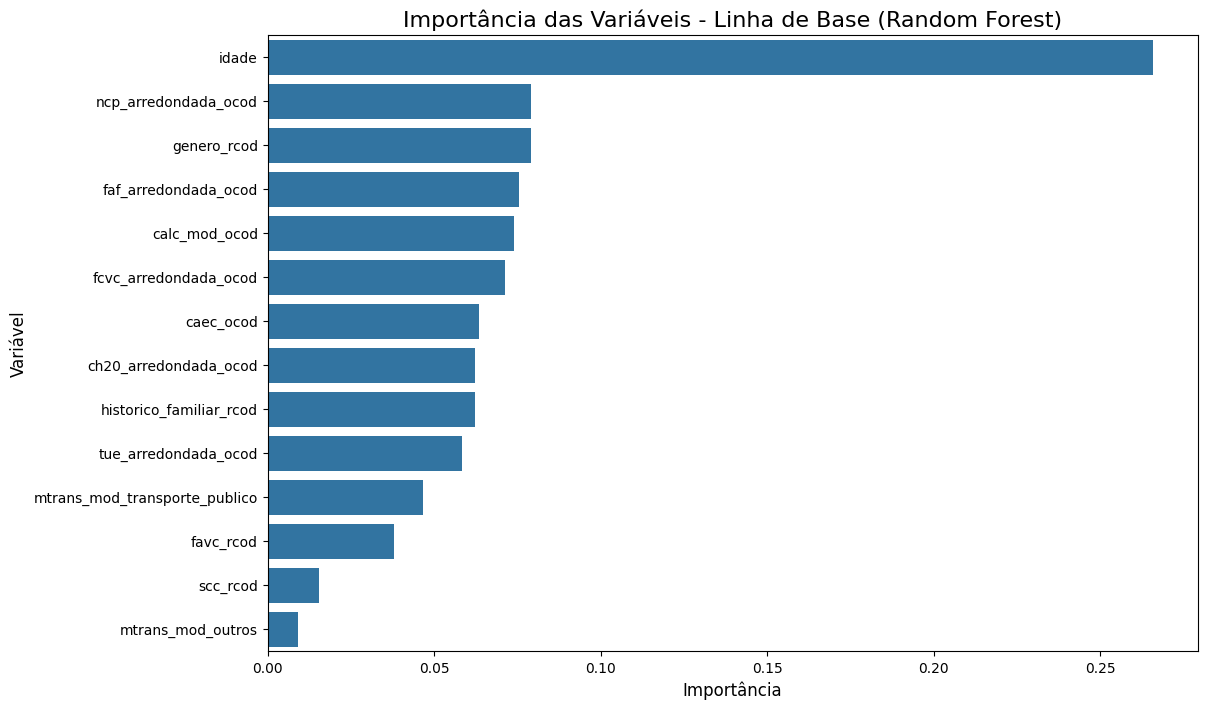

Capturando métricas da linha de base
Modelo Baseline avaliado e salvo.


In [116]:
print("\n--- Treinando Modelo 1: Linha de Base (Random Forest) ---")

modelo_base = RandomForestClassifier(random_state=42, n_jobs=-1)
modelo_base.fit(X_treino, y_treino)

y_previsao_base = modelo_base.predict(X_teste)

print("\nRelatório de Classificação (Linha de base):")
print(classification_report(y_teste, y_previsao_base))
plotar_matriz_confusao(y_teste, y_previsao_base,
                       "Matriz de Confusão - Linha de Base (Random Forest)",
                       cmap='YlGn')

plotar_importancia_variaveis(modelo_base, X_treino.columns,
                          "Importância das Variáveis - Linha de Base (Random Forest)")

print("Capturando métricas da linha de base")
metricas_todos_modelos['rf_linha_base'] = extrair_metricas_completas(y_teste, y_previsao_base)

print("Modelo Baseline avaliado e salvo.")

**Tabela comparativa**

In [117]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base
Geral    Acurácia                  0.8203
Classe 0 precision                 0.8026
         recall                    0.8714
         f1-score                  0.8356
Classe 1 precision                 0.8769
         recall                    0.9500
         f1-score                  0.9120
Classe 2 precision                 0.9848
         recall                    1.0000
         f1-score                  0.9924
Classe 3 precision                 0.7231
         recall                    0.8704
         f1-score                  0.7899
Classe 4 precision                 0.6441
         recall                    0.6552
         f1-score                  0.6496
Classe 5 precision                 0.8864
         recall                    0.6724
         f1-score                  0.7647
Classe 6 precision                 0.8333
         recall                    0.6897
         f1-score                  0.7547
Médias   Macro Avg (f1)            0.8141
         Weighted Avg (f1)         0.8184


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1                  \
              Acurácia precision recall f1-score precision recall f1-score   
rf_linha_base   0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   0.9120   

               Classe 2                  ... Classe 4           Classe 5  \
              precision recall f1-score  ...   recall f1-score precision   
rf_linha_base    0.9848 1.0000   0.9924  ...   0.6552   0.6496    0.8864   

                               Classe 6                         Médias  \
              recall f1-score precision recall f1-score Macro Avg (f1)   
rf_linha_base 0.6724   0.7647    0.8333 0.6897   0.7547         0.8141   

                                 
              Weighted Avg (f1)  
rf_linha_base            0.8184  

[1 rows x 24 columns]

### **Otimização modelo (Random Forest)**


--- Treinando Modelo 2: Otimização (GridSearchCV)
Iniciando GridSearchCV...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Melhores Parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Relatório de Classificação (Otimizado):
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        70
           1       0.89      0.95      0.92        60
           2       0.98      1.00      0.99        65
           3       0.72      0.89      0.79        54
           4       0.66      0.64      0.65        58
           5       0.87      0.69      0.77        58
           6       0.84      0.72      0.78        58

    accuracy                           0.83       423
   macro avg       0.83      0.83      0.82       423
weighted avg       0.83      0.83      0.83       423



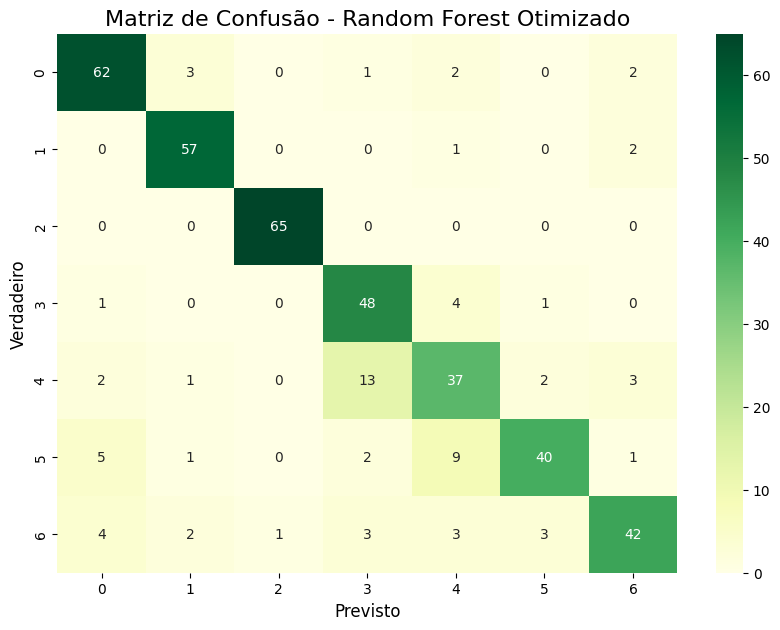

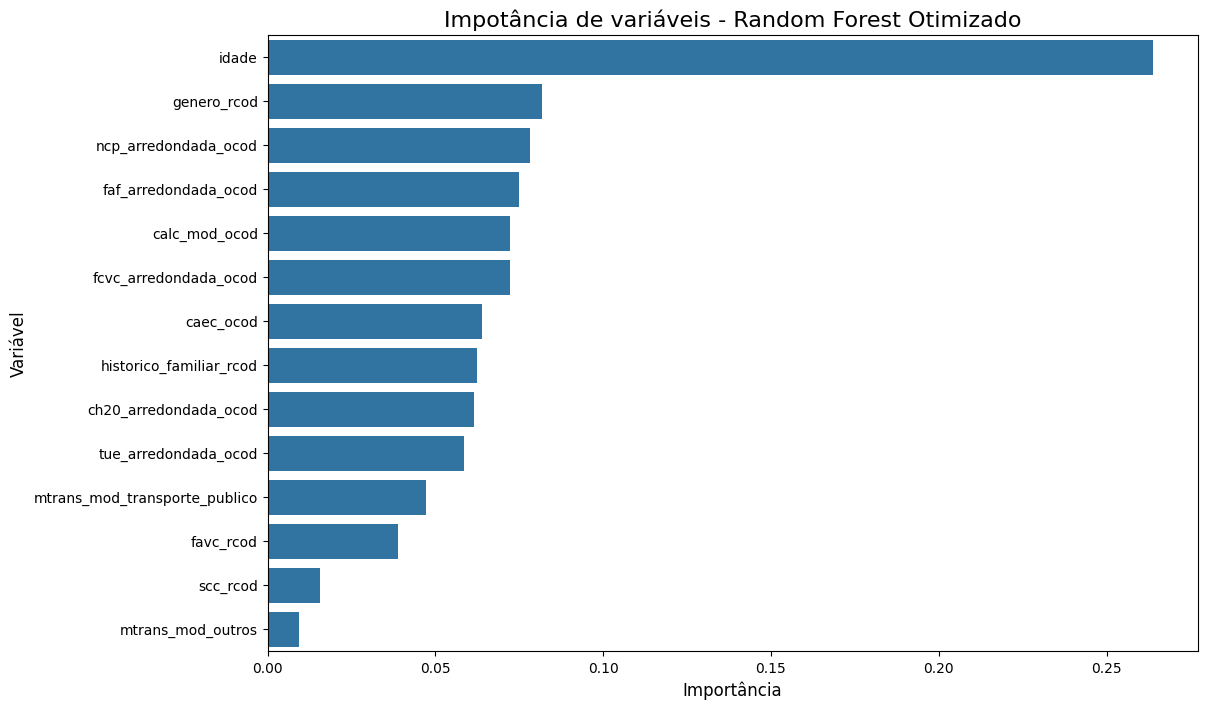

Capturando métricas do Modelo Otimizado...
Modelo Otimizado avaliado e salvo.


In [118]:
print("\n--- Treinando Modelo 2: Otimização (GridSearchCV)")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5]
}

print("Iniciando GridSearchCV...")
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)
rf_grid_search.fit(X_treino, y_treino)
best_model = rf_grid_search.best_estimator_
print(f"\nMelhores Parâmetros: {rf_grid_search.best_params_}")

y_pred_final = best_model.predict(X_teste)

print("\nRelatório de Classificação (Otimizado):")
print(classification_report(y_teste, y_pred_final))
plotar_matriz_confusao(y_teste, y_pred_final,
                       "Matriz de Confusão - Random Forest Otimizado",
                       cmap='YlGn')

plotar_importancia_variaveis(best_model, X_treino.columns,
                          "Impotância de variáveis - Random Forest Otimizado")

print("Capturando métricas do Modelo Otimizado...")
metricas_todos_modelos['rf_otimizado'] = extrair_metricas_completas(y_teste, y_pred_final)

print("Modelo Otimizado avaliado e salvo.")

**Tabela comparativa**

In [119]:
print("\n--- Tabela Comparativa de Desempenho---")

exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho---

--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado
Geral    Acurácia                  0.8203        0.8298
Classe 0 precision                 0.8026        0.8378
         recall                    0.8714        0.8857
         f1-score                  0.8356        0.8611
Classe 1 precision                 0.8769        0.8906
         recall                    0.9500        0.9500
         f1-score                  0.9120        0.9194
Classe 2 precision                 0.9848        0.9848
         recall                    1.0000        1.0000
         f1-score                  0.9924        0.9924
Classe 3 precision                 0.7231        0.7164
         recall                    0.8704        0.8889
         f1-score                  0.7899        0.7934
Classe 4 precision                 0.6441        0.6607
         recall                    0.6552        0.6379
         f1-score                  0.6496        0.6491
Classe 5 precision                 0.8864        0.8696
         recall                    0.6724        0.6897
         f1-score                  0.7647        0.7692
Classe 6 precision                 0.8333        0.8400
         recall                    0.6897        0.7241
         f1-score                  0.7547        0.7778
Médias   Macro Avg (f1)            0.8141        0.8232
         Weighted Avg (f1)         0.8184        0.8278


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1                  \
              Acurácia precision recall f1-score precision recall f1-score   
rf_otimizado    0.8298    0.8378 0.8857   0.8611    0.8906 0.9500   0.9194   
rf_linha_base   0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   0.9120   

               Classe 2                  ... Classe 4           Classe 5  \
              precision recall f1-score  ...   recall f1-score precision   
rf_otimizado     0.9848 1.0000   0.9924  ...   0.6379   0.6491    0.8696   
rf_linha_base    0.9848 1.0000   0.9924  ...   0.6552   0.6496    0.8864   

                               Classe 6                         Médias  \
              recall f1-score precision recall f1-score Macro Avg (f1)   
rf_otimizado  0.6897   0.7692    0.8400 0.7241   0.7778         0.8232   
rf_linha_base 0.6724   0.7647    0.8333 0.6897   0.7547         0.8141   

                                 
              Weighted Avg (f1)  
rf_otimizado             0.8278  
rf_linha_base            0.8184  

[2 rows x 24 columns]

## **Modelo XGBoost**

### **Treinamento XGBoost**

Iniciando treinamento do XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:27:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Relatório de Classificação (XGBoost):
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        70
           1       0.88      0.95      0.91        60
           2       0.98      1.00      0.99        65
           3       0.81      0.87      0.84        54
           4       0.66      0.66      0.66        58
           5       0.79      0.71      0.75        58
           6       0.85      0.71      0.77        58

    accuracy                           0.82       423
   macro avg       0.82      0.82      0.82       423
weighted avg       0.82      0.82      0.82       423



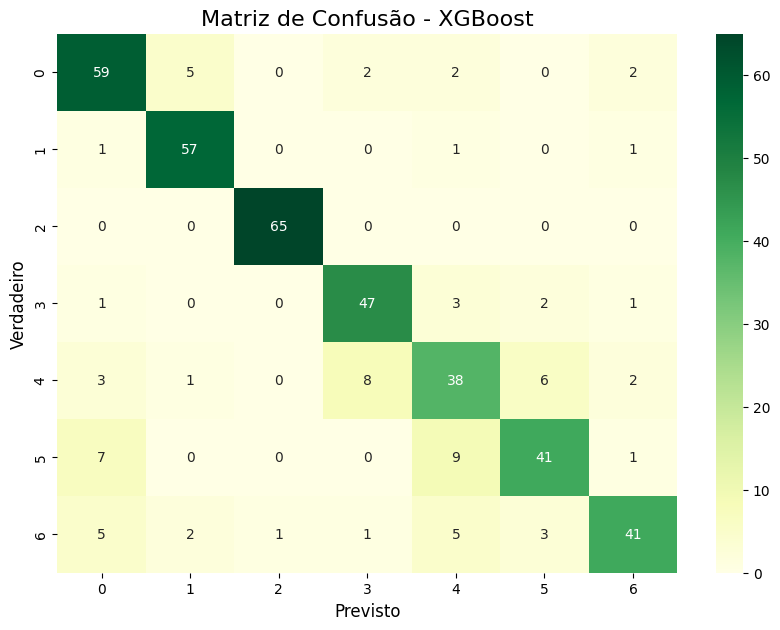

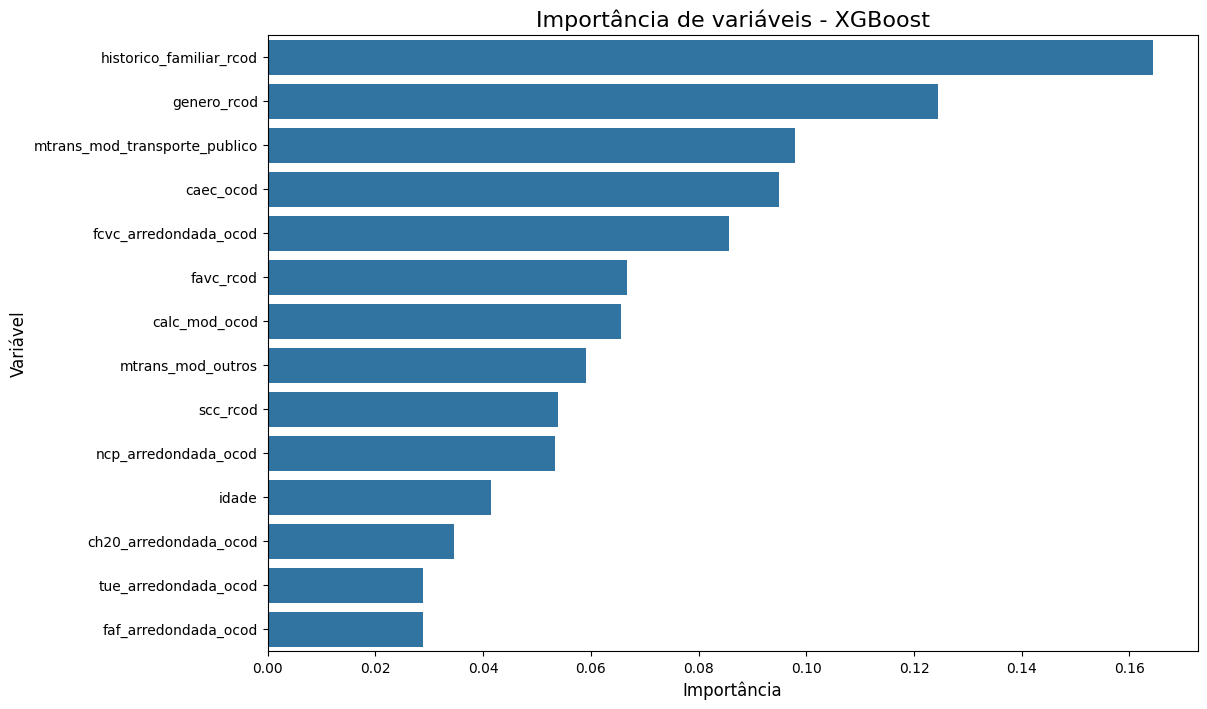

Capturando métricas do XGBoost...
Modelo XGBoost avaliado e salvo.


In [120]:
print("Iniciando treinamento do XGBoost...")
xgb_modelo = XGBClassifier(
    objective='multi:softmax',
    num_class=7,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

xgb_modelo.fit(X_treino, y_treino)

y_pred_xgb = xgb_modelo.predict(X_teste)

print("\nRelatório de Classificação (XGBoost):")
print(classification_report(y_teste, y_pred_xgb))

plotar_matriz_confusao(y_teste, y_pred_xgb,
                       "Matriz de Confusão - XGBoost",
                       cmap='YlGn')

plotar_importancia_variaveis(xgb_modelo, X_treino.columns,
                          "Importância de variáveis - XGBoost")

print("Capturando métricas do XGBoost...")
metricas_todos_modelos['xgboost'] = extrair_metricas_completas(y_teste, y_pred_xgb)

print("Modelo XGBoost avaliado e salvo.")

**Tabela comparativa**

In [121]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost
Geral    Acurácia                  0.8203        0.8298   0.8227
Classe 0 precision                 0.8026        0.8378   0.7763
         recall                    0.8714        0.8857   0.8429
         f1-score                  0.8356        0.8611   0.8082
Classe 1 precision                 0.8769        0.8906   0.8769
         recall                    0.9500        0.9500   0.9500
         f1-score                  0.9120        0.9194   0.9120
Classe 2 precision                 0.9848        0.9848   0.9848
         recall                    1.0000        1.0000   1.0000
         f1-score                  0.9924        0.9924   0.9924
Classe 3 precision                 0.7231        0.7164   0.8103
         recall                    0.8704        0.8889   0.8704
         f1-score                  0.7899        0.7934   0.8393
Classe 4 precision                 0.6441        0.6607   0.6552
         recall                    0.6552        0.6379   0.6552
         f1-score                  0.6496        0.6491   0.6552
Classe 5 precision                 0.8864        0.8696   0.7885
         recall                    0.6724        0.6897   0.7069
         f1-score                  0.7647        0.7692   0.7455
Classe 6 precision                 0.8333        0.8400   0.8542
         recall                    0.6897        0.7241   0.7069
         f1-score                  0.7547        0.7778   0.7736
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180
         Weighted Avg (f1)         0.8184        0.8278   0.8209


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1                  \
              Acurácia precision recall f1-score precision recall f1-score   
rf_otimizado    0.8298    0.8378 0.8857   0.8611    0.8906 0.9500   0.9194   
xgboost         0.8227    0.7763 0.8429   0.8082    0.8769 0.9500   0.9120   
rf_linha_base   0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   0.9120   

               Classe 2                  ... Classe 4           Classe 5  \
              precision recall f1-score  ...   recall f1-score precision   
rf_otimizado     0.9848 1.0000   0.9924  ...   0.6379   0.6491    0.8696   
xgboost          0.9848 1.0000   0.9924  ...   0.6552   0.6552    0.7885   
rf_linha_base    0.9848 1.0000   0.9924  ...   0.6552   0.6496    0.8864   

                               Classe 6                         Médias  \
              recall f1-score precision recall f1-score Macro Avg (f1)   
rf_otimizado  0.6897   0.7692    0.8400 0.7241   0.7778         0.8232   
xgboost       0.7069   0.7455    0.8542 0.7069   0.7736         0.8180   
rf_linha_base 0.6724   0.7647    0.8333 0.6897   0.7547         0.8141   

                                 
              Weighted Avg (f1)  
rf_otimizado             0.8278  
xgboost                  0.8209  
rf_linha_base            0.8184  

[3 rows x 24 columns]

### **Otimização do modelo XGBoost**


--- Treinando Modelo 4: XGBoost Otimizado (GridSearchCV) ---
Iniciando GridSearchCV para XGBoost...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Melhores Parâmetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}

Relatório de Classificação (XGBoost Otimizado):
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        70
           1       0.87      0.92      0.89        60
           2       0.98      1.00      0.99        65
           3       0.81      0.85      0.83        54
           4       0.65      0.67      0.66        58
           5       0.86      0.74      0.80        58
           6       0.82      0.71      0.76        58

    accuracy                           0.83       423
   macro avg       0.82      0.82      0.82       423
weighted avg       0.83      0.83      0.82       423



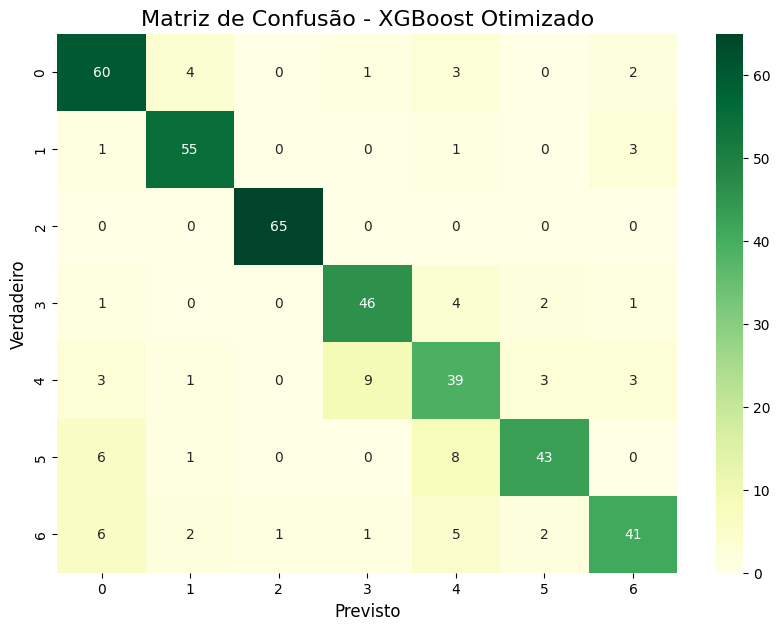

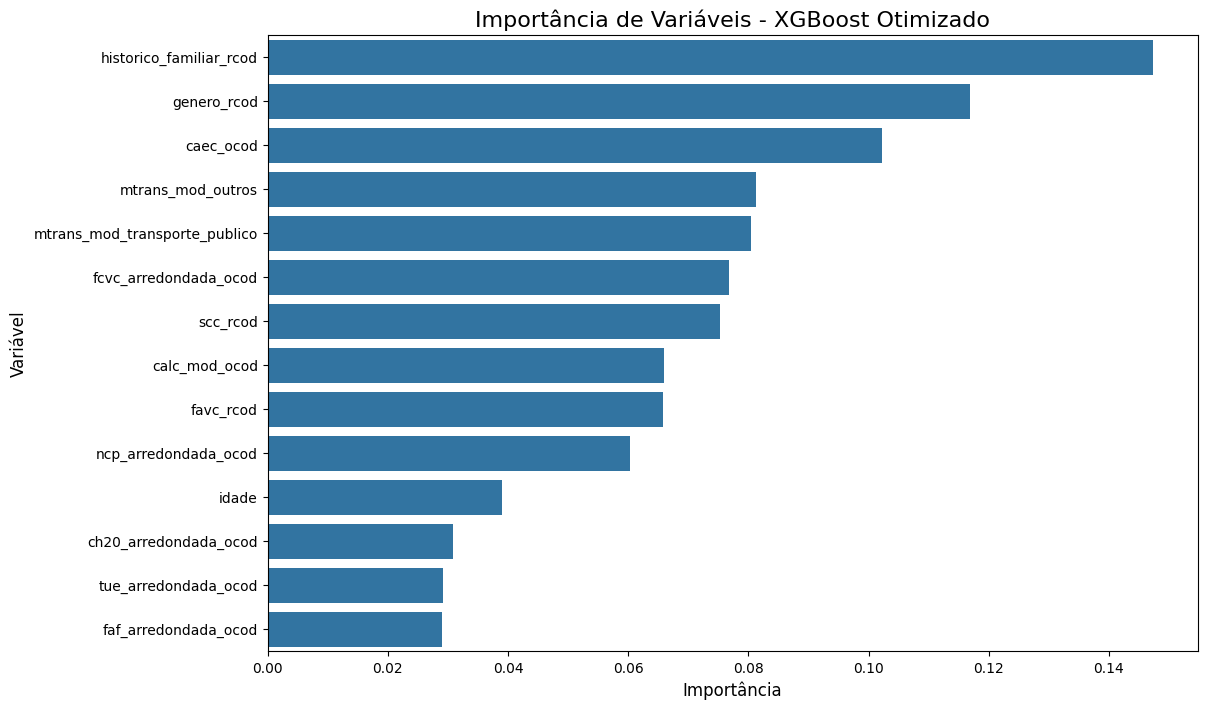

Capturando métricas do XGBoost Otimizado...
Modelo XGBoost Otimizado avaliado e salvo.


In [122]:
print("\n--- Treinando Modelo 4: XGBoost Otimizado (GridSearchCV) ---")

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}


print("Iniciando GridSearchCV para XGBoost...")
xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(
        objective='multi:softmax',
        num_class=7,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    ),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

xgb_grid_search.fit(X_treino, y_treino)
xgb_melhor_modelo = xgb_grid_search.best_estimator_
print(f"\nMelhores Parâmetros: {xgb_grid_search.best_params_}")

y_previsao_xgb_otimizado = xgb_melhor_modelo.predict(X_teste)

print("\nRelatório de Classificação (XGBoost Otimizado):")
print(classification_report(y_teste, y_previsao_xgb_otimizado))

plotar_matriz_confusao(y_teste, y_previsao_xgb_otimizado,
                       "Matriz de Confusão - XGBoost Otimizado",
                       cmap='YlGn')

plotar_importancia_variaveis(xgb_melhor_modelo, X_treino.columns,
                          "Importância de Variáveis - XGBoost Otimizado")

print("Capturando métricas do XGBoost Otimizado...")
metricas_todos_modelos['xgboost_otimizado'] = extrair_metricas_completas(y_teste, y_previsao_xgb_otimizado)

print("Modelo XGBoost Otimizado avaliado e salvo.")

**Tabela comparativa**

In [123]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost  \
Geral    Acurácia                  0.8203        0.8298   0.8227   
Classe 0 precision                 0.8026        0.8378   0.7763   
         recall                    0.8714        0.8857   0.8429   
         f1-score                  0.8356        0.8611   0.8082   
Classe 1 precision                 0.8769        0.8906   0.8769   
         recall                    0.9500        0.9500   0.9500   
         f1-score                  0.9120        0.9194   0.9120   
Classe 2 precision                 0.9848        0.9848   0.9848   
         recall                    1.0000        1.0000   1.0000   
         f1-score                  0.9924        0.9924   0.9924   
Classe 3 precision                 0.7231        0.7164   0.8103   
         recall                    0.8704        0.8889   0.8704   
         f1-score                  0.7899        0.7934   0.8393   
Classe 4 precision                 0.6441        0.6607   0.6552   
         recall                    0.6552        0.6379   0.6552   
         f1-score                  0.6496        0.6491   0.6552   
Classe 5 precision                 0.8864        0.8696   0.7885   
         recall                    0.6724        0.6897   0.7069   
         f1-score                  0.7647        0.7692   0.7455   
Classe 6 precision                 0.8333        0.8400   0.8542   
         recall                    0.6897        0.7241   0.7069   
         f1-score                  0.7547        0.7778   0.7736   
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180   
         Weighted Avg (f1)         0.8184        0.8278   0.8209   

                            xgboost_otimizado  
Geral    Acurácia                      0.8251  
Classe 0 precision                     0.7792  
         recall                        0.8571  
         f1-score                      0.8163  
Classe 1 precision                     0.8730  
         recall                        0.9167  
         f1-score                      0.8943  
Classe 2 precision                     0.9848  
         recall                        1.0000  
         f1-score                      0.9924  
Classe 3 precision                     0.8070  
         recall                        0.8519  
         f1-score                      0.8288  
Classe 4 precision                     0.6500  
         recall                        0.6724  
         f1-score                      0.6610  
Classe 5 precision                     0.8600  
         recall                        0.7414  
         f1-score                      0.7963  
Classe 6 precision                     0.8200  
         recall                        0.7069  
         f1-score                      0.7593  
Médias   Macro Avg (f1)                0.8212  
         Weighted Avg (f1)             0.8242


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1         \
                  Acurácia precision recall f1-score precision recall   
rf_otimizado        0.8298    0.8378 0.8857   0.8611    0.8906 0.9500   
xgboost_otimizado   0.8251    0.7792 0.8571   0.8163    0.8730 0.9167   
xgboost             0.8227    0.7763 0.8429   0.8082    0.8769 0.9500   
rf_linha_base       0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   

                            Classe 2                  ... Classe 4           \
                  f1-score precision recall f1-score  ...   recall f1-score   
rf_otimizado        0.9194    0.9848 1.0000   0.9924  ...   0.6379   0.6491   
xgboost_otimizado   0.8943    0.9848 1.0000   0.9924  ...   0.6724   0.6610   
xgboost             0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6552   
rf_linha_base       0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6496   

                   Classe 5                  Classe 6                  \
                  precision recall f1-score precision recall f1-score   
rf_otimizado         0.8696 0.6897   0.7692    0.8400 0.7241   0.7778   
xgboost_otimizado    0.8600 0.7414   0.7963    0.8200 0.7069   0.7593   
xgboost              0.7885 0.7069   0.7455    0.8542 0.7069   0.7736   
rf_linha_base        0.8864 0.6724   0.7647    0.8333 0.6897   0.7547   

                          Médias                    
                  Macro Avg (f1) Weighted Avg (f1)  
rf_otimizado              0.8232            0.8278  
xgboost_otimizado         0.8212            0.8242  
xgboost                   0.8180            0.8209  
rf_linha_base             0.8141            0.8184  

[4 rows x 24 columns]

## **SVM (Support Vector Machine)**



### **Treinamento SVM**


--- Treinando Modelo 5: SVM (Support Vector Machine) ---
Iniciando treinamento do SVM

Relatório de Classificação (SVM):
              precision    recall  f1-score   support

           0       0.63      0.79      0.70        70
           1       0.78      0.97      0.87        60
           2       0.96      1.00      0.98        65
           3       0.73      0.81      0.77        54
           4       0.68      0.66      0.67        58
           5       0.72      0.53      0.61        58
           6       0.77      0.47      0.58        58

    accuracy                           0.75       423
   macro avg       0.75      0.75      0.74       423
weighted avg       0.75      0.75      0.74       423



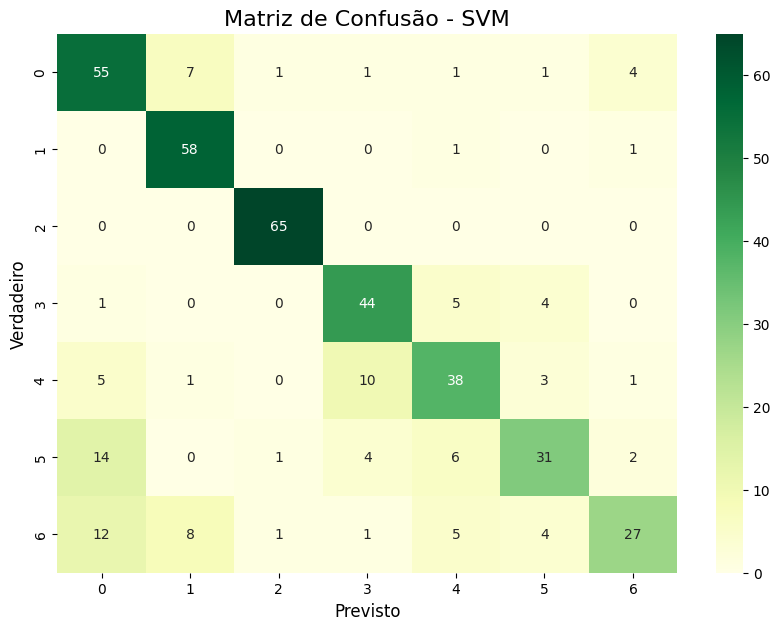

Capturando métricas do SVM...
Modelo SVM avaliado e salvo.


In [124]:
print("\n--- Treinando Modelo 5: SVM (Support Vector Machine) ---")

print("Iniciando treinamento do SVM")
svm_model = SVC(
    random_state=42,
    kernel='rbf'
)

svm_model.fit(X_treino, y_treino)

y_previsao_svm = svm_model.predict(X_teste)

print("\nRelatório de Classificação (SVM):")
print(classification_report(y_teste, y_previsao_svm))

plotar_matriz_confusao(y_teste, y_previsao_svm,
                       "Matriz de Confusão - SVM",
                       cmap='YlGn')

print("Capturando métricas do SVM...")
metricas_todos_modelos['svm'] = extrair_metricas_completas(y_teste, y_previsao_svm)

print("Modelo SVM avaliado e salvo.")

**Tabela comparativa**

In [125]:
print("\n--- Tabela Comparativa ---")

exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa ---

--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost  \
Geral    Acurácia                  0.8203        0.8298   0.8227   
Classe 0 precision                 0.8026        0.8378   0.7763   
         recall                    0.8714        0.8857   0.8429   
         f1-score                  0.8356        0.8611   0.8082   
Classe 1 precision                 0.8769        0.8906   0.8769   
         recall                    0.9500        0.9500   0.9500   
         f1-score                  0.9120        0.9194   0.9120   
Classe 2 precision                 0.9848        0.9848   0.9848   
         recall                    1.0000        1.0000   1.0000   
         f1-score                  0.9924        0.9924   0.9924   
Classe 3 precision                 0.7231        0.7164   0.8103   
         recall                    0.8704        0.8889   0.8704   
         f1-score                  0.7899        0.7934   0.8393   
Classe 4 precision                 0.6441        0.6607   0.6552   
         recall                    0.6552        0.6379   0.6552   
         f1-score                  0.6496        0.6491   0.6552   
Classe 5 precision                 0.8864        0.8696   0.7885   
         recall                    0.6724        0.6897   0.7069   
         f1-score                  0.7647        0.7692   0.7455   
Classe 6 precision                 0.8333        0.8400   0.8542   
         recall                    0.6897        0.7241   0.7069   
         f1-score                  0.7547        0.7778   0.7736   
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180   
         Weighted Avg (f1)         0.8184        0.8278   0.8209   

                            xgboost_otimizado    svm  
Geral    Acurácia                      0.8251 0.7518  
Classe 0 precision                     0.7792 0.6322  
         recall                        0.8571 0.7857  
         f1-score                      0.8163 0.7006  
Classe 1 precision                     0.8730 0.7838  
         recall                        0.9167 0.9667  
         f1-score                      0.8943 0.8657  
Classe 2 precision                     0.9848 0.9559  
         recall                        1.0000 1.0000  
         f1-score                      0.9924 0.9774  
Classe 3 precision                     0.8070 0.7333  
         recall                        0.8519 0.8148  
         f1-score                      0.8288 0.7719  
Classe 4 precision                     0.6500 0.6786  
         recall                        0.6724 0.6552  
         f1-score                      0.6610 0.6667  
Classe 5 precision                     0.8600 0.7209  
         recall                        0.7414 0.5345  
         f1-score                      0.7963 0.6139  
Classe 6 precision                     0.8200 0.7714  
         recall                        0.7069 0.4655  
         f1-score                      0.7593 0.5806  
Médias   Macro Avg (f1)                0.8212 0.7396  
         Weighted Avg (f1)             0.8242 0.7427


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1         \
                  Acurácia precision recall f1-score precision recall   
rf_otimizado        0.8298    0.8378 0.8857   0.8611    0.8906 0.9500   
xgboost_otimizado   0.8251    0.7792 0.8571   0.8163    0.8730 0.9167   
xgboost             0.8227    0.7763 0.8429   0.8082    0.8769 0.9500   
rf_linha_base       0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   
svm                 0.7518    0.6322 0.7857   0.7006    0.7838 0.9667   

                            Classe 2                  ... Classe 4           \
                  f1-score precision recall f1-score  ...   recall f1-score   
rf_otimizado        0.9194    0.9848 1.0000   0.9924  ...   0.6379   0.6491   
xgboost_otimizado   0.8943    0.9848 1.0000   0.9924  ...   0.6724   0.6610   
xgboost             0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6552   
rf_linha_base       0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6496   
svm                 0.8657    0.9559 1.0000   0.9774  ...   0.6552   0.6667   

                   Classe 5                  Classe 6                  \
                  precision recall f1-score precision recall f1-score   
rf_otimizado         0.8696 0.6897   0.7692    0.8400 0.7241   0.7778   
xgboost_otimizado    0.8600 0.7414   0.7963    0.8200 0.7069   0.7593   
xgboost              0.7885 0.7069   0.7455    0.8542 0.7069   0.7736   
rf_linha_base        0.8864 0.6724   0.7647    0.8333 0.6897   0.7547   
svm                  0.7209 0.5345   0.6139    0.7714 0.4655   0.5806   

                          Médias                    
                  Macro Avg (f1) Weighted Avg (f1)  
rf_otimizado              0.8232            0.8278  
xgboost_otimizado         0.8212            0.8242  
xgboost                   0.8180            0.8209  
rf_linha_base             0.8141            0.8184  
svm                       0.7396            0.7427  

[5 rows x 24 columns]

## **Regressão logistica**


--- Treinando Modelo 6: Regressão Logística ---
Iniciando treinamento da Regressão Logística...

Relatório de Classificação (Regressão Logística):
              precision    recall  f1-score   support

           0       0.47      0.70      0.56        70
           1       0.55      0.87      0.68        60
           2       0.90      1.00      0.95        65
           3       0.58      0.65      0.61        54
           4       0.61      0.47      0.53        58
           5       0.55      0.36      0.44        58
           6       0.64      0.12      0.20        58

    accuracy                           0.61       423
   macro avg       0.62      0.59      0.57       423
weighted avg       0.62      0.61      0.57       423



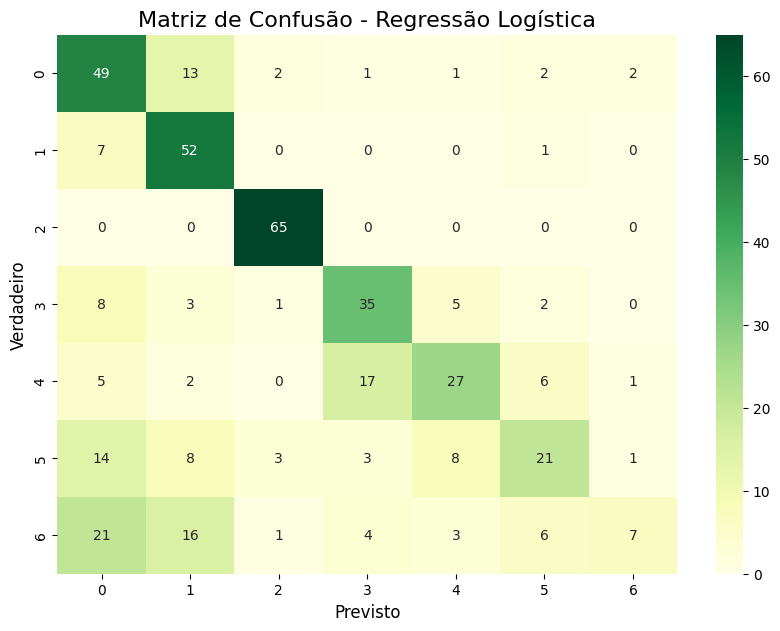

Capturando métricas da Regressão Logística...
Modelo de Regressão Logística avaliado e salvo.


In [126]:
print("\n--- Treinando Modelo 6: Regressão Logística ---")

print("Iniciando treinamento da Regressão Logística...")
log_reg_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    n_jobs=-1
)

log_reg_model.fit(X_treino, y_treino)

y_previsao_rg = log_reg_model.predict(X_teste)

# 4. Avaliação (Visual)
print("\nRelatório de Classificação (Regressão Logística):")
print(classification_report(y_teste, y_previsao_rg))

plotar_matriz_confusao(y_teste, y_previsao_rg,
                       "Matriz de Confusão - Regressão Logística",
                       cmap='YlGn')

print("Capturando métricas da Regressão Logística...")
metricas_todos_modelos['regressao_logistica'] = extrair_metricas_completas(y_teste, y_previsao_rg)

print("Modelo de Regressão Logística avaliado e salvo.")

## **Tabela comparativa primeiro treinamento**

In [127]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost  \
Geral    Acurácia                  0.8203        0.8298   0.8227   
Classe 0 precision                 0.8026        0.8378   0.7763   
         recall                    0.8714        0.8857   0.8429   
         f1-score                  0.8356        0.8611   0.8082   
Classe 1 precision                 0.8769        0.8906   0.8769   
         recall                    0.9500        0.9500   0.9500   
         f1-score                  0.9120        0.9194   0.9120   
Classe 2 precision                 0.9848        0.9848   0.9848   
         recall                    1.0000        1.0000   1.0000   
         f1-score                  0.9924        0.9924   0.9924   
Classe 3 precision                 0.7231        0.7164   0.8103   
         recall                    0.8704        0.8889   0.8704   
         f1-score                  0.7899        0.7934   0.8393   
Classe 4 precision                 0.6441        0.6607   0.6552   
         recall                    0.6552        0.6379   0.6552   
         f1-score                  0.6496        0.6491   0.6552   
Classe 5 precision                 0.8864        0.8696   0.7885   
         recall                    0.6724        0.6897   0.7069   
         f1-score                  0.7647        0.7692   0.7455   
Classe 6 precision                 0.8333        0.8400   0.8542   
         recall                    0.6897        0.7241   0.7069   
         f1-score                  0.7547        0.7778   0.7736   
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180   
         Weighted Avg (f1)         0.8184        0.8278   0.8209   

                            xgboost_otimizado    svm  regressao_logistica  
Geral    Acurácia                      0.8251 0.7518               0.6052  
Classe 0 precision                     0.7792 0.6322               0.4712  
         recall                        0.8571 0.7857               0.7000  
         f1-score                      0.8163 0.7006               0.5632  
Classe 1 precision                     0.8730 0.7838               0.5532  
         recall                        0.9167 0.9667               0.8667  
         f1-score                      0.8943 0.8657               0.6753  
Classe 2 precision                     0.9848 0.9559               0.9028  
         recall                        1.0000 1.0000               1.0000  
         f1-score                      0.9924 0.9774               0.9489  
Classe 3 precision                     0.8070 0.7333               0.5833  
         recall                        0.8519 0.8148               0.6481  
         f1-score                      0.8288 0.7719               0.6140  
Classe 4 precision                     0.6500 0.6786               0.6136  
         recall                        0.6724 0.6552               0.4655  
         f1-score                      0.6610 0.6667               0.5294  
Classe 5 precision                     0.8600 0.7209               0.5526  
         recall                        0.7414 0.5345               0.3621  
         f1-score                      0.7963 0.6139               0.4375  
Classe 6 precision                     0.8200 0.7714               0.6364  
         recall                        0.7069 0.4655               0.1207  
         f1-score                      0.7593 0.5806               0.2029  
Médias   Macro Avg (f1)                0.8212 0.7396               0.5673  
         Weighted Avg (f1)             0.8242 0.7427               0.5736


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1         \
                    Acurácia precision recall f1-score precision recall   
rf_otimizado          0.8298    0.8378 0.8857   0.8611    0.8906 0.9500   
xgboost_otimizado     0.8251    0.7792 0.8571   0.8163    0.8730 0.9167   
xgboost               0.8227    0.7763 0.8429   0.8082    0.8769 0.9500   
rf_linha_base         0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   
svm                   0.7518    0.6322 0.7857   0.7006    0.7838 0.9667   
regressao_logistica   0.6052    0.4712 0.7000   0.5632    0.5532 0.8667   

                              Classe 2                  ... Classe 4           \
                    f1-score precision recall f1-score  ...   recall f1-score   
rf_otimizado          0.9194    0.9848 1.0000   0.9924  ...   0.6379   0.6491   
xgboost_otimizado     0.8943    0.9848 1.0000   0.9924  ...   0.6724   0.6610   
xgboost               0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6552   
rf_linha_base         0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6496   
svm                   0.8657    0.9559 1.0000   0.9774  ...   0.6552   0.6667   
regressao_logistica   0.6753    0.9028 1.0000   0.9489  ...   0.4655   0.5294   

                     Classe 5                  Classe 6                  \
                    precision recall f1-score precision recall f1-score   
rf_otimizado           0.8696 0.6897   0.7692    0.8400 0.7241   0.7778   
xgboost_otimizado      0.8600 0.7414   0.7963    0.8200 0.7069   0.7593   
xgboost                0.7885 0.7069   0.7455    0.8542 0.7069   0.7736   
rf_linha_base          0.8864 0.6724   0.7647    0.8333 0.6897   0.7547   
svm                    0.7209 0.5345   0.6139    0.7714 0.4655   0.5806   
regressao_logistica    0.5526 0.3621   0.4375    0.6364 0.1207   0.2029   

                            Médias                    
                    Macro Avg (f1) Weighted Avg (f1)  
rf_otimizado                0.8232            0.8278  
xgboost_otimizado           0.8212            0.8242  
xgboost                     0.8180            0.8209  
rf_linha_base               0.8141            0.8184  
svm                         0.7396            0.7427  
regressao_logistica         0.5673            0.5736  

[6 rows x 24 columns]

## **Análise primeiro bloco de treinamento**


Os modelos de Árvore (RF) e modelos de Boosting (XGBoost) e ambos atingiram o máximo de 82-83% de acerto.

O modelo (SVM) performou pior que os outros 2.

Conclusão: Os algoritmos de árvore (RF e XGBoost) se mostraram mais eficazes para este projeto.

O fato de eles terem chegado ao mesmo resultado usando lógicas diferentes (Idade vs. Histórico Familiar) indica que o gargalo do projeto está nas suas variáveis atuais.


Análise exploratótia vs importância de variável.

**Resultados do gráfico importância de variável:**

**Melhor modelo:** Random Forest (Otimizado)

**Melhor variável Random Forest:**  `idade`

-O Random Forest (baseline e otimizado) mostra que esta é a variável mais importante, mas o XGBoost não utilizou a mesma com tanta importância.

-Esse modelo está encontrando um padrão de "idade" que o XGBoost não vê.

A Melhor variável para o modelo **RandomForest** é  `idade` , enquanto **XGBoost** a considerada em 11º lugar.



**variáveis que deveriam ser monitoradas segundo a análise exploratória:**

`scc`, `mtrans`, `caec`, `calc`, `ncp`, `faf`

**O que identicamos após o treinamento:**

`scc`: A `scc_rcod` teve importância quase nula em todos os 5 modelos.

Sugestão inicial: Retirar do modelo caso a importância da variável fosse pequena.

`mtrans`:  O treinamento otimizado (XGBoost) colocou `mtrans_mod_transporte_publico` e `mtrans_outros` como quarta e quinta variável em nível de importância

Sugestão inicial: Devido a raridade da categorias bicileta, moto e caminhando, foi criada uma nova categoria (outros) juntando as 3, no entanto essa categoria ainda é considerada rara. por isso foi indicado verificar importância da variável e teste A/B.

`caec`: O treinamento otimizado (XGBoost) colocou a variável `caec_ocod` como terceira em nível de importância

Sugestão inicial: Caso a importância da variável  e o teste A/B voltem sem relevância ou indicando overfitting retirar a mesma do treinamento. Devido a raridade de categorias.

`calc`: A variável `calc_mod_ocod`ficou e uma zona intermediária de de imprtância  para o modelo XGBoost (otimizaddo).

Sugestão inicial: Devido a raridade das categorias frequenteente e sempre , foi criada uma nova categoria freq_sempre para minimizar o risco de impacto. No entanto, foi sugerido verificar importância da variável e teste A/B

`ncp`: a Variável ncp_arredondada_ocod ficou com a 'decima variável em importância

Sugestão inicial: Monitorar risco devido a raridade da categoria 4. Usar as técnicas de importância de variável e Teste A/B pós treinamento.

`faf`: O treinamento XGBoost (otimizaddo) colocou faf_arredondada_ocod em último lugar

Sugestão inicial: Monitorar devido a raridade da categoria 3.

`tue`: O treinamento otimizado (XGBoost) colocou a `tue_arredondada_ocod` em  penúltimo lugar.

Sugestão: As variáveis parecem ser apenas ruído para o melhor modelo XGBoost(otimizado). Removê-las pode melhorar a performance.

**Novos treinamentos**

- Segundo bloco de Treinamento: Remover variaveis identificadas como possíveis ruídos

- Terceiro bloco de treinamento: Criar novas variaveis de interação.

# **Segundo bloco de Treinamento XGBoost**

**Hipótese:** Simplificação (Removendo Ruído)

Remover as variáveis scc_rcod, faf_arredondada_ocod e tue_arredondada_ocod, que identificamos como "ruído".

## **Removendo as colunas indentificadas com ruído**

In [128]:
print("Preparando os dados XGBoost simplificados")

variaveis_para_remover = [
    'scc_rcod',
    'faf_arredondada_ocod',
    'tue_arredondada_ocod'
]

df_teste_simplificado = df.drop(columns=variaveis_para_remover)
print(f"variaveis removidas: {variaveis_para_remover}")

Preparando os dados XGBoost simplificados
variaveis removidas: ['scc_rcod', 'faf_arredondada_ocod', 'tue_arredondada_ocod']


## **Separando dados em treino e teste**

In [129]:
print("Separando X e y do dataset XGBoost simplificado")
coluna_alvo_simp = 'classificacao_peso_corporal_rcod'
X_simp = df_teste_simplificado.drop(columns=[coluna_alvo_simp])
y_simp = df_teste_simplificado[coluna_alvo_simp].astype(int)

X_treino_simp, X_teste_simp, y_treino_simp, y_teste_simp = train_test_split(
    X_simp,
    y_simp,
    test_size=0.2,
    random_state=42,
    stratify=y_simp
)
print("Separado X e y do dataset XGBoost simplificado")





Separando X e y do dataset XGBoost simplificado
Separado X e y do dataset XGBoost simplificado


## **stadartScaler na coluna `idade` dataset simplificado**

In [130]:
scaler = StandardScaler()

scaler.fit(X_treino_simp[['idade']])

X_treino_simp['idade'] = scaler.transform(X_treino_simp[['idade']])
X_teste_simp['idade'] = scaler.transform(X_teste_simp[['idade']])

print("Coluna 'idade' escalada corretamente após a divisão para o dataset simplificado.")


Coluna 'idade' escalada corretamente após a divisão para o dataset simplificado.


## **Treinando o modelo XGBoost otimizado**

Utilizado modelo de XGboost que o GridSearchCV encontrou.

Treinando o modelo 'XGBoost Otimizado' no novo dataset simplificado...
Novo modelo treinado com sucesso no dataset simplificado.

Relatório de Classificação (XGBoost Simplificado):
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        70
           1       0.85      0.83      0.84        60
           2       0.97      1.00      0.98        65
           3       0.81      0.81      0.81        54
           4       0.70      0.74      0.72        58
           5       0.76      0.67      0.72        58
           6       0.67      0.62      0.64        58

    accuracy                           0.79       423
   macro avg       0.79      0.78      0.78       423
weighted avg       0.79      0.79      0.79       423



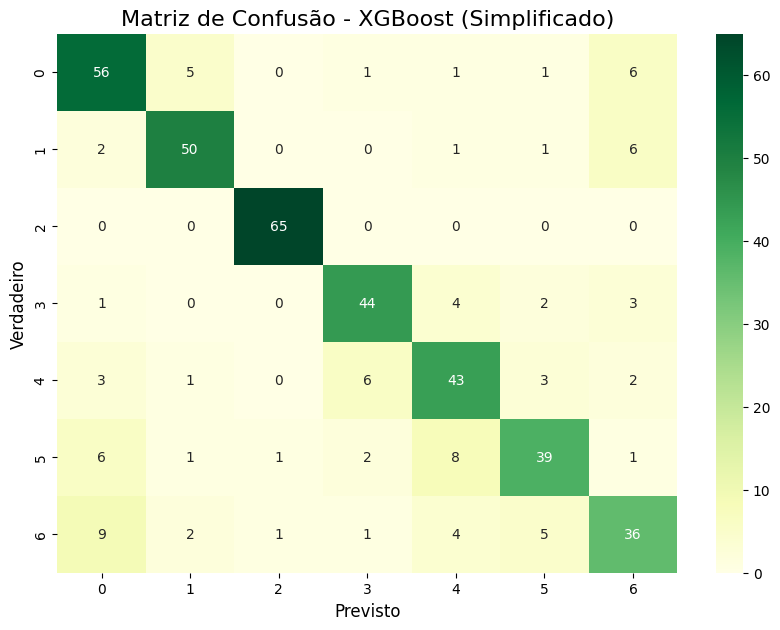

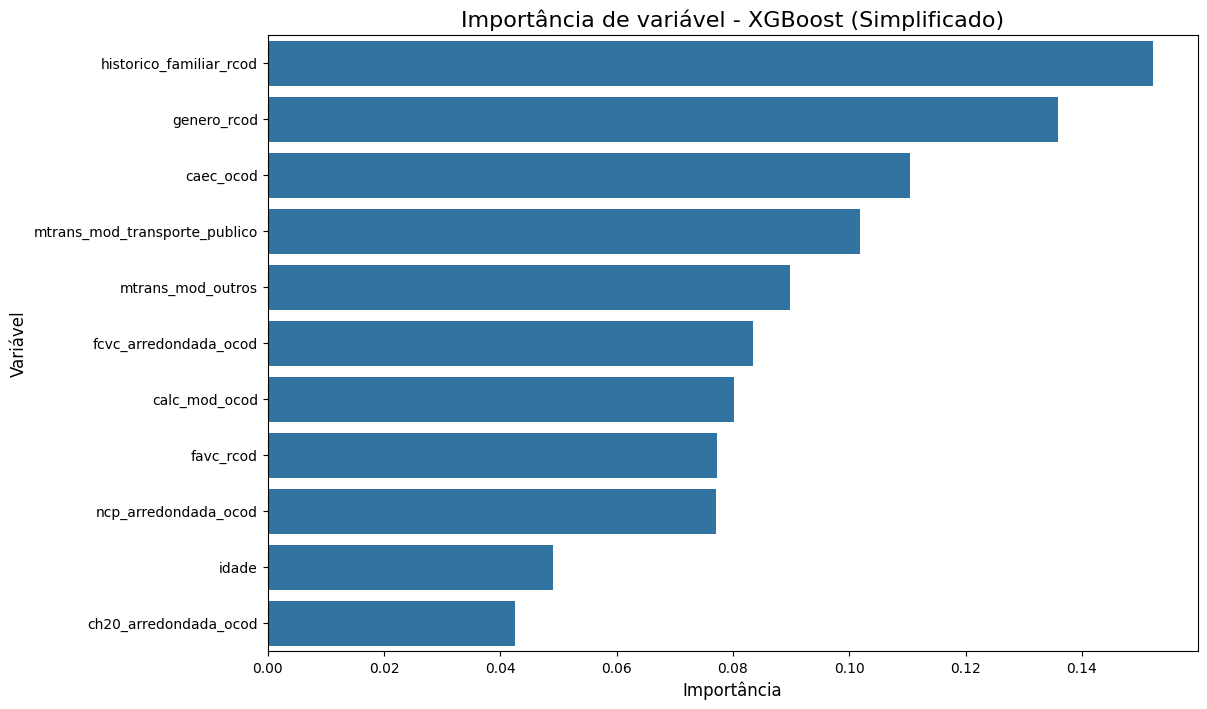

Capturando métricas do XGBoost (Simplificado)...
Modelo XGBoost (Simplificado) avaliado e salvo.


In [131]:
try:

    print("Treinando o modelo 'XGBoost Otimizado' no novo dataset simplificado...")

    if 'xgb_grid_search' not in locals():
        print("Erro: A variável 'xgb_grid_search' não foi encontrada.")
        print("Por favor, re-execute o xgb_grid_search primeiro.")
        raise NameError("xgb_grid_search not found")

    melhores_parametros_xgb = xgb_grid_search.best_params_

    modelo_xgb_otimizado = XGBClassifier(
        objective='multi:softmax',
        num_class=7,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss',
        **melhores_parametros_xgb
    )


    modelo_xgb_otimizado.fit(X_treino_simp, y_treino_simp)
    print("Novo modelo treinado com sucesso no dataset simplificado.")
except NameError:
    print("Erro: A variável 'melhores_parametros_xgb' não foi encontrada.")
    print("Por favor, re-execute xgb_grid_search primeiro.")
    raise

y_previsao_xgb_simp = modelo_xgb_otimizado.predict(X_teste_simp)

print("\nRelatório de Classificação (XGBoost Simplificado):")
print(classification_report(y_teste_simp, y_previsao_xgb_simp))

plotar_matriz_confusao(y_teste_simp, y_previsao_xgb_simp,
                       "Matriz de Confusão - XGBoost (Simplificado)",
                       cmap='YlGn')

plotar_importancia_variaveis(modelo_xgb_otimizado, X_treino_simp.columns,
                          "Importância de variável - XGBoost (Simplificado)")

print("Capturando métricas do XGBoost (Simplificado)...")
metricas_todos_modelos['xgb_simplificado'] = extrair_metricas_completas(y_teste_simp, y_previsao_xgb_simp)

print("Modelo XGBoost (Simplificado) avaliado e salvo.")

**Tabela comparativa**

In [132]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost  \
Geral    Acurácia                  0.8203        0.8298   0.8227   
Classe 0 precision                 0.8026        0.8378   0.7763   
         recall                    0.8714        0.8857   0.8429   
         f1-score                  0.8356        0.8611   0.8082   
Classe 1 precision                 0.8769        0.8906   0.8769   
         recall                    0.9500        0.9500   0.9500   
         f1-score                  0.9120        0.9194   0.9120   
Classe 2 precision                 0.9848        0.9848   0.9848   
         recall                    1.0000        1.0000   1.0000   
         f1-score                  0.9924        0.9924   0.9924   
Classe 3 precision                 0.7231        0.7164   0.8103   
         recall                    0.8704        0.8889   0.8704   
         f1-score                  0.7899        0.7934   0.8393   
Classe 4 precision                 0.6441        0.6607   0.6552   
         recall                    0.6552        0.6379   0.6552   
         f1-score                  0.6496        0.6491   0.6552   
Classe 5 precision                 0.8864        0.8696   0.7885   
         recall                    0.6724        0.6897   0.7069   
         f1-score                  0.7647        0.7692   0.7455   
Classe 6 precision                 0.8333        0.8400   0.8542   
         recall                    0.6897        0.7241   0.7069   
         f1-score                  0.7547        0.7778   0.7736   
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180   
         Weighted Avg (f1)         0.8184        0.8278   0.8209   

                            xgboost_otimizado    svm  regressao_logistica  \
Geral    Acurácia                      0.8251 0.7518               0.6052   
Classe 0 precision                     0.7792 0.6322               0.4712   
         recall                        0.8571 0.7857               0.7000   
         f1-score                      0.8163 0.7006               0.5632   
Classe 1 precision                     0.8730 0.7838               0.5532   
         recall                        0.9167 0.9667               0.8667   
         f1-score                      0.8943 0.8657               0.6753   
Classe 2 precision                     0.9848 0.9559               0.9028   
         recall                        1.0000 1.0000               1.0000   
         f1-score                      0.9924 0.9774               0.9489   
Classe 3 precision                     0.8070 0.7333               0.5833   
         recall                        0.8519 0.8148               0.6481   
         f1-score                      0.8288 0.7719               0.6140   
Classe 4 precision                     0.6500 0.6786               0.6136   
         recall                        0.6724 0.6552               0.4655   
         f1-score                      0.6610 0.6667               0.5294   
Classe 5 precision                     0.8600 0.7209               0.5526   
         recall                        0.7414 0.5345               0.3621   
         f1-score                      0.7963 0.6139               0.4375   
Classe 6 precision                     0.8200 0.7714               0.6364   
         recall                        0.7069 0.4655               0.1207   
         f1-score                      0.7593 0.5806               0.2029   
Médias   Macro Avg (f1)                0.8212 0.7396               0.5673   
         Weighted Avg (f1)             0.8242 0.7427               0.5736   

                            xgb_simplificado  
Geral    Acurácia                     0.7872  
Classe 0 precision                    0.7273  
         recall                       0.8000  
         f1-score                     0.7619  
Classe 1 precision                    0.8475  
         recall                       0.8333  
         f1-score                     0.8403  
Classe 2 precision       


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1         \
                    Acurácia precision recall f1-score precision recall   
rf_otimizado          0.8298    0.8378 0.8857   0.8611    0.8906 0.9500   
xgboost_otimizado     0.8251    0.7792 0.8571   0.8163    0.8730 0.9167   
xgboost               0.8227    0.7763 0.8429   0.8082    0.8769 0.9500   
rf_linha_base         0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   
xgb_simplificado      0.7872    0.7273 0.8000   0.7619    0.8475 0.8333   
svm                   0.7518    0.6322 0.7857   0.7006    0.7838 0.9667   
regressao_logistica   0.6052    0.4712 0.7000   0.5632    0.5532 0.8667   

                              Classe 2                  ... Classe 4           \
                    f1-score precision recall f1-score  ...   recall f1-score   
rf_otimizado          0.9194    0.9848 1.0000   0.9924  ...   0.6379   0.6491   
xgboost_otimizado     0.8943    0.9848 1.0000   0.9924  ...   0.6724   0.6610   
xgboost               0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6552   
rf_linha_base         0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6496   
xgb_simplificado      0.8403    0.9701 1.0000   0.9848  ...   0.7414   0.7227   
svm                   0.8657    0.9559 1.0000   0.9774  ...   0.6552   0.6667   
regressao_logistica   0.6753    0.9028 1.0000   0.9489  ...   0.4655   0.5294   

                     Classe 5                  Classe 6                  \
                    precision recall f1-score precision recall f1-score   
rf_otimizado           0.8696 0.6897   0.7692    0.8400 0.7241   0.7778   
xgboost_otimizado      0.8600 0.7414   0.7963    0.8200 0.7069   0.7593   
xgboost                0.7885 0.7069   0.7455    0.8542 0.7069   0.7736   
rf_linha_base          0.8864 0.6724   0.7647    0.8333 0.6897   0.7547   
xgb_simplificado       0.7647 0.6724   0.7156    0.6667 0.6207   0.6429   
svm                    0.7209 0.5345   0.6139    0.7714 0.4655   0.5806   
regressao_logistica    0.5526 0.3621   0.4375    0.6364 0.1207   0.2029   

                            Médias                    
                    Macro Avg (f1) Weighted Avg (f1)  
rf_otimizado                0.8232            0.8278  
xgboost_otimizado           0.8212            0.8242  
xgboost                     0.8180            0.8209  
rf_linha_base               0.8141            0.8184  
xgb_simplificado            0.7833            0.7860  
svm                         0.7396            0.7427  
regressao_logistica         0.5673            0.5736  

[7 rows x 24 columns]

## **Análise**

Hipótese (Simplificação) Falhou: Ao remover as variaveis scc_rcod, faf_arredondada_ocod e tue_arredondada_ocod, a performance do melhor modelo caiu 3-4%.

Isso significa que, embora essas variaveis (faf, tue, scc) tivessem uma importância individual muito baixa no gráfico, elas não eram ruído.

Dessa forma manter o nosso conjunto original de variaveis é a melhor opção.

# **Segundo bloco de treinamento Random Forest**

**Hipótese:** Simplificação (Removendo Ruído)

Para o modelo Random Forest vamos remover apenas a variável scc_rcod que identificamos como "ruído" para o modelo Random Forest.

## **Removendo as colunas indentificadas com ruído**

In [133]:
print("Preparando os dados Random Forest simplificados...")

variaveis_para_remover_rf = [
    'scc_rcod',

]

df_teste_simplificado_rf = df.drop(columns=variaveis_para_remover_rf)
print(f"variaveis removidas: {variaveis_para_remover_rf}")

Preparando os dados Random Forest simplificados...
variaveis removidas: ['scc_rcod']


## **Separando dados em treino e teste**

In [134]:
print("Separando X e y do dataset Random Forest simplificado")
coluna_alvo_simp_rf = 'classificacao_peso_corporal_rcod'
X_simp_rf = df_teste_simplificado_rf.drop(columns=[coluna_alvo_simp_rf])
y_simp_rf = df_teste_simplificado_rf[coluna_alvo_simp_rf].astype(int)

X_treino_simp_rf, X_teste_simp_rf, y_treino_simp_rf, y_teste_simp_rf = train_test_split(
    X_simp_rf,
    y_simp_rf,
    test_size=0.2,
    random_state=42,
    stratify=y_simp
)
print("Separado X e y do dataset simplificado Random Forest")





Separando X e y do dataset Random Forest simplificado
Separado X e y do dataset simplificado Random Forest


## **stadartScaler na coluna `idade` dataset simplificado**

In [135]:
scaler = StandardScaler()

scaler.fit(X_treino_simp_rf[['idade']])

X_treino_simp_rf['idade'] = scaler.transform(X_treino_simp_rf[['idade']])
X_teste_simp_rf['idade'] = scaler.transform(X_teste_simp_rf[['idade']])

print("Coluna 'idade' escalada corretamente após a divisão para o dataset simplificado.")


Coluna 'idade' escalada corretamente após a divisão para o dataset simplificado.


## **Treinamento o modelo RandomForest otimizado**


--- Treinando o modelo 'Random Forest Otimizado' no novo dataset simplificado...
Usando os parâmetros ótimos do RF: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Treinando o novo modelo RF no dataset simplificado Random Forest

Relatório de Classificação (RF Simplificado):
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        70
           1       0.89      0.95      0.92        60
           2       0.98      1.00      0.99        65
           3       0.76      0.89      0.82        54
           4       0.68      0.69      0.68        58
           5       0.87      0.71      0.78        58
           6       0.82      0.72      0.77        58

    accuracy                           0.84       423
   macro avg       0.84      0.83      0.83       423
weighted avg       0.84      0.84      0.84       423



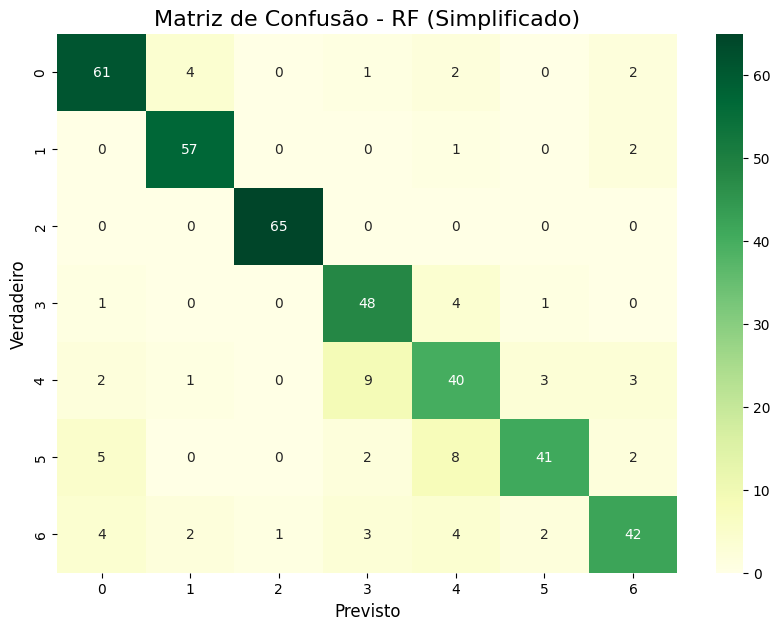

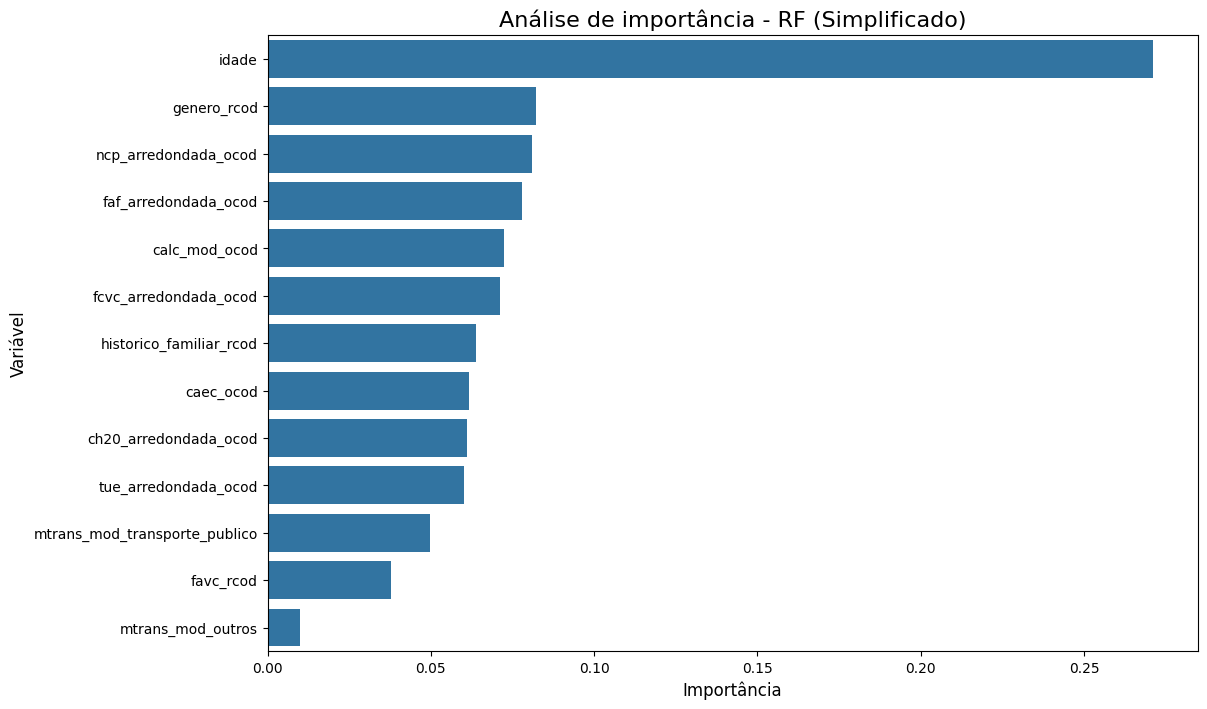

Capturando métricas do RF (Simplificado)...
Modelo RF (Simplificado) avaliado e salvo.


In [136]:
print("\n--- Treinando o modelo 'Random Forest Otimizado' no novo dataset simplificado...")

try:

    melhores_parametros_rf = rf_grid_search.best_params_
    print(f"Usando os parâmetros ótimos do RF: {melhores_parametros_rf}")

    modelo_simp_rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **melhores_parametros_rf
    )

    print("Treinando o novo modelo RF no dataset simplificado Random Forest")
    modelo_simp_rf.fit(X_treino_simp_rf, y_treino_simp_rf)

except NameError:
    print("Erro: A variável 'grid_search' não foi encontrada.")
    print("Por favor, re-execute o grid search rf primeiro.")
    raise

y_previsao_simp_rf = modelo_simp_rf.predict(X_teste_simp_rf)

print("\nRelatório de Classificação (RF Simplificado):")
print(classification_report(y_teste_simp_rf, y_previsao_simp_rf))

plotar_matriz_confusao(y_teste_simp_rf, y_previsao_simp_rf,
                       "Matriz de Confusão - RF (Simplificado)",
                       cmap='YlGn')

plotar_importancia_variaveis(modelo_simp_rf, X_treino_simp_rf.columns,
                          "Análise de importância - RF (Simplificado)")

print("Capturando métricas do RF (Simplificado)...")
metricas_todos_modelos['rf_simplificado'] = extrair_metricas_completas(y_teste_simp_rf, y_previsao_simp_rf)

print("Modelo RF (Simplificado) avaliado e salvo.")

**Tabela comparativa**

In [137]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost  \
Geral    Acurácia                  0.8203        0.8298   0.8227   
Classe 0 precision                 0.8026        0.8378   0.7763   
         recall                    0.8714        0.8857   0.8429   
         f1-score                  0.8356        0.8611   0.8082   
Classe 1 precision                 0.8769        0.8906   0.8769   
         recall                    0.9500        0.9500   0.9500   
         f1-score                  0.9120        0.9194   0.9120   
Classe 2 precision                 0.9848        0.9848   0.9848   
         recall                    1.0000        1.0000   1.0000   
         f1-score                  0.9924        0.9924   0.9924   
Classe 3 precision                 0.7231        0.7164   0.8103   
         recall                    0.8704        0.8889   0.8704   
         f1-score                  0.7899        0.7934   0.8393   
Classe 4 precision                 0.6441        0.6607   0.6552   
         recall                    0.6552        0.6379   0.6552   
         f1-score                  0.6496        0.6491   0.6552   
Classe 5 precision                 0.8864        0.8696   0.7885   
         recall                    0.6724        0.6897   0.7069   
         f1-score                  0.7647        0.7692   0.7455   
Classe 6 precision                 0.8333        0.8400   0.8542   
         recall                    0.6897        0.7241   0.7069   
         f1-score                  0.7547        0.7778   0.7736   
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180   
         Weighted Avg (f1)         0.8184        0.8278   0.8209   

                            xgboost_otimizado    svm  regressao_logistica  \
Geral    Acurácia                      0.8251 0.7518               0.6052   
Classe 0 precision                     0.7792 0.6322               0.4712   
         recall                        0.8571 0.7857               0.7000   
         f1-score                      0.8163 0.7006               0.5632   
Classe 1 precision                     0.8730 0.7838               0.5532   
         recall                        0.9167 0.9667               0.8667   
         f1-score                      0.8943 0.8657               0.6753   
Classe 2 precision                     0.9848 0.9559               0.9028   
         recall                        1.0000 1.0000               1.0000   
         f1-score                      0.9924 0.9774               0.9489   
Classe 3 precision                     0.8070 0.7333               0.5833   
         recall                        0.8519 0.8148               0.6481   
         f1-score                      0.8288 0.7719               0.6140   
Classe 4 precision                     0.6500 0.6786               0.6136   
         recall                        0.6724 0.6552               0.4655   
         f1-score                      0.6610 0.6667               0.5294   
Classe 5 precision                     0.8600 0.7209               0.5526   
         recall                        0.7414 0.5345               0.3621   
         f1-score                      0.7963 0.6139               0.4375   
Classe 6 precision                     0.8200 0.7714               0.6364   
         recall                        0.7069 0.4655               0.1207   
         f1-score                      0.7593 0.5806               0.2029   
Médias   Macro Avg (f1)                0.8212 0.7396               0.5673   
         Weighted Avg (f1)             0.8242 0.7427               0.5736   

                            xgb_simplificado  rf_simplificado  
Geral    Acurácia                     0.7872           0.8369  
Classe 0 precision                    0.7273           0.8356  
         recall                       0.8000           0.8714  
         f1-score                     0.7619           0.8531  
Classe 1 precision                    0.8475           0.8906  
         recall  


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1         \
                    Acurácia precision recall f1-score precision recall   
rf_simplificado       0.8369    0.8356 0.8714   0.8531    0.8906 0.9500   
rf_otimizado          0.8298    0.8378 0.8857   0.8611    0.8906 0.9500   
xgboost_otimizado     0.8251    0.7792 0.8571   0.8163    0.8730 0.9167   
xgboost               0.8227    0.7763 0.8429   0.8082    0.8769 0.9500   
rf_linha_base         0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   
xgb_simplificado      0.7872    0.7273 0.8000   0.7619    0.8475 0.8333   
svm                   0.7518    0.6322 0.7857   0.7006    0.7838 0.9667   
regressao_logistica   0.6052    0.4712 0.7000   0.5632    0.5532 0.8667   

                              Classe 2                  ... Classe 4           \
                    f1-score precision recall f1-score  ...   recall f1-score   
rf_simplificado       0.9194    0.9848 1.0000   0.9924  ...   0.6897   0.6838   
rf_otimizado          0.9194    0.9848 1.0000   0.9924  ...   0.6379   0.6491   
xgboost_otimizado     0.8943    0.9848 1.0000   0.9924  ...   0.6724   0.6610   
xgboost               0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6552   
rf_linha_base         0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6496   
xgb_simplificado      0.8403    0.9701 1.0000   0.9848  ...   0.7414   0.7227   
svm                   0.8657    0.9559 1.0000   0.9774  ...   0.6552   0.6667   
regressao_logistica   0.6753    0.9028 1.0000   0.9489  ...   0.4655   0.5294   

                     Classe 5                  Classe 6                  \
                    precision recall f1-score precision recall f1-score   
rf_simplificado        0.8723 0.7069   0.7810    0.8235 0.7241   0.7706   
rf_otimizado           0.8696 0.6897   0.7692    0.8400 0.7241   0.7778   
xgboost_otimizado      0.8600 0.7414   0.7963    0.8200 0.7069   0.7593   
xgboost                0.7885 0.7069   0.7455    0.8542 0.7069   0.7736   
rf_linha_base          0.8864 0.6724   0.7647    0.8333 0.6897   0.7547   
xgb_simplificado       0.7647 0.6724   0.7156    0.6667 0.6207   0.6429   
svm                    0.7209 0.5345   0.6139    0.7714 0.4655   0.5806   
regressao_logistica    0.5526 0.3621   0.4375    0.6364 0.1207   0.2029   

                            Médias                    
                    Macro Avg (f1) Weighted Avg (f1)  
rf_simplificado             0.8315            0.8353  
rf_otimizado                0.8232            0.8278  
xgboost_otimizado           0.8212            0.8242  
xgboost                     0.8180            0.8209  
rf_linha_base               0.8141            0.8184  
xgb_simplificado            0.7833            0.7860  
svm                         0.7396            0.7427  
regressao_logistica         0.5673            0.5736  

[8 rows x 24 columns]

## **Análise**

Hipótese (Simplificação) Falhou: Ao remover as variaveis scc_rcod, faf_arredondada_ocod e tue_arredondada_ocod, a performance do melhor modelo caiu 3-4%.

Isso significa que, embora essas variaveis (faf, tue, scc) tivessem uma importância individual muito baixa no gráfico, elas não eram ruído.

Dessa forma manter o nosso conjunto original de variaveis é a melhor opção.

# **Terceiro bloco de Treinamento**

**Hipótese:** Criar variaveis de Interação.

O objetivo é que o modelo entenda as conexões que o gráfico de importâncias de fetatures retiorno com importantes

idade (favorita do RF) com historico_familiar_rcod (favorita do XGBoost)

historico_familiar_rcod com genero_rcod (as duas favoritas do XGBoost)

## **Criando variaveis**

**`hist_x_genero`:** Combina as duas favoritas do XGBoost

**`idade_x_hist`:** Combina a favorita do RF (idade) com a favorita do XGBoost (histórico)

**`idade_x_genero`:** Combina as duas favoritas do RF (ou favorita do RF + segunda do XGB)

In [138]:
df_teste_interacao = pd.read_csv('https://raw.githubusercontent.com/bernardo-seg/tech-challenge-obesidade/refs/heads/main/dados/obesidade_processado.csv')
print("Criando variaveis de interação...")

df_teste_interacao['hist_x_genero'] = df_teste_interacao['historico_familiar_rcod'] * df_teste_interacao['genero_rcod']

df_teste_interacao['idade_x_hist'] = df_teste_interacao['idade'] * df_teste_interacao['historico_familiar_rcod']

df_teste_interacao['idade_x_genero'] = df_teste_interacao['idade'] * df_teste_interacao['genero_rcod']
print("Novas variaveis criadas:", ['hist_x_genero', 'idade_x_hist', 'idade_x_genero'])

Criando variaveis de interação...
Novas variaveis criadas: ['hist_x_genero', 'idade_x_hist', 'idade_x_genero']


## **Separando em treino e teste**

In [139]:
print("Separando X e y do dataset com interações...")
coluna_alvo_inter = 'classificacao_peso_corporal_rcod'
X_inter = df_teste_interacao.drop(columns=[coluna_alvo_inter])
y_inter = df_teste_interacao[coluna_alvo_inter].astype(int)

X_treino_inter, X_teste_inter, y_treino_inter, y_teste_inter = train_test_split(
    X_inter,
    y_inter,
    test_size=0.2,
    random_state=42,
    stratify=y_inter
)

print("Separando X e y do dataset com interações...")

Separando X e y do dataset com interações...
Separando X e y do dataset com interações...


## **Treinamento do modelo XGBoost**

Vamos usar os melhores parâmetros que encontramos anteriormente para treinar um novo modelo de XGBoost, diretamente no dataset com as variaveis de interação.

Criando e treinando o modelo XGBoost (Otimizado) no dataset com interações...
Novo modelo treinado com sucesso.

Relatório de Classificação (XGBoost com Interações):
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        70
           1       0.89      0.90      0.89        60
           2       0.98      1.00      0.99        65
           3       0.78      0.80      0.79        54
           4       0.65      0.64      0.64        58
           5       0.82      0.78      0.80        58
           6       0.77      0.69      0.73        58

    accuracy                           0.82       423
   macro avg       0.81      0.81      0.81       423
weighted avg       0.81      0.82      0.81       423



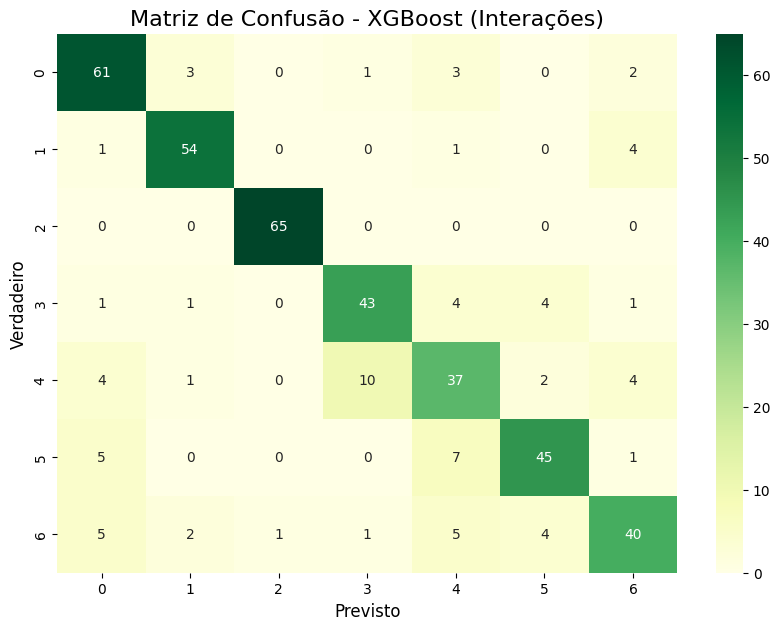

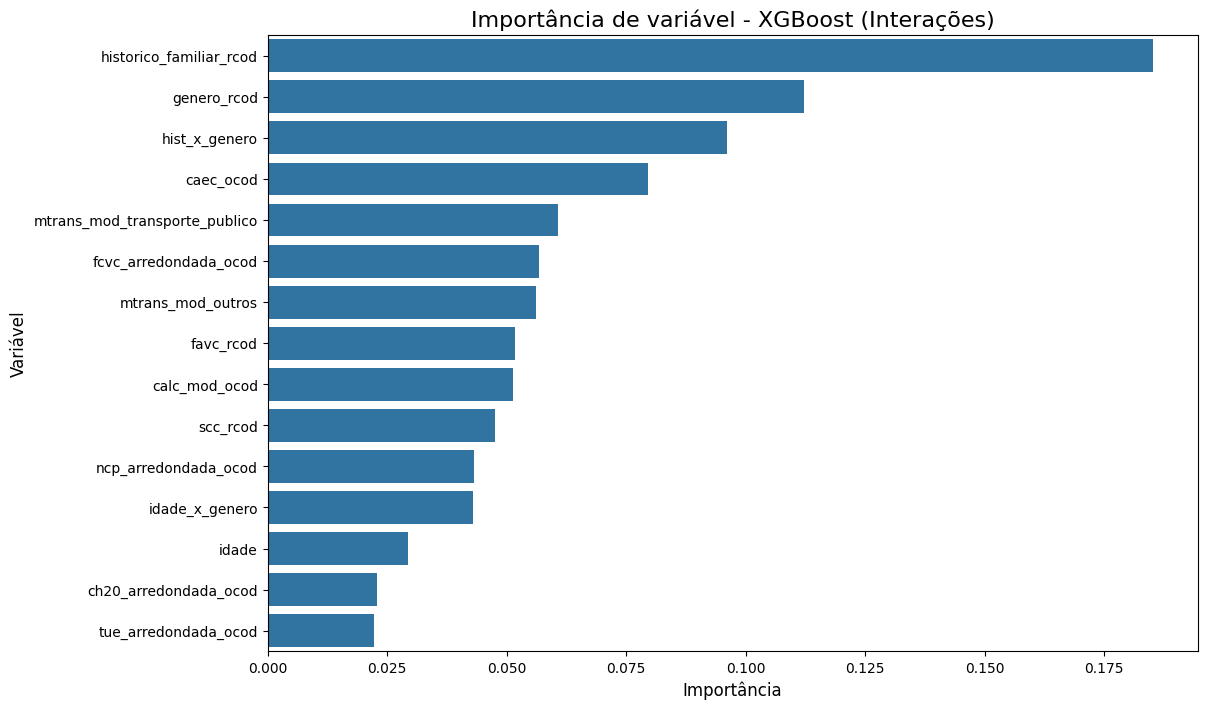

Capturando métricas do XGBoost (Interações)...
Modelo XGBoost (Interações) avaliado e salvo.


In [140]:
try:
    print("Criando e treinando o modelo XGBoost (Otimizado) no dataset com interações...")

    if 'xgb_grid_search' not in locals():
        print("Erro: A variável 'xgb_grid_search' não foi encontrada.")
        print("Por favor, re-execute a Célula 7 primeiro.")
        raise NameError("xgb_grid_search not found")

    melhores_parametros_xgb = xgb_grid_search.best_params_

    xgb_modelo_inter = XGBClassifier(
        objective='multi:softmax',
        num_class=7,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss',
        **melhores_parametros_xgb
    )

    xgb_modelo_inter.fit(X_treino_inter, y_treino_inter)
    print("Novo modelo treinado com sucesso.")

except NameError as e:
    print(f"Erro: {e}")
    print("Por favor, certifique-se de que as células anteriores foram executadas, especialmente a Célula 7.")
    raise

y_previsao_xgb_inter = xgb_modelo_inter.predict(X_teste_inter)

print("\nRelatório de Classificação (XGBoost com Interações):")
print(classification_report(y_teste_inter, y_previsao_xgb_inter))

plotar_matriz_confusao(y_teste_inter, y_previsao_xgb_inter,
                       "Matriz de Confusão - XGBoost (Interações)",
                       cmap='YlGn')

plotar_importancia_variaveis(xgb_modelo_inter, X_treino_inter.columns,
                          "Importância de variável - XGBoost (Interações)")

print("Capturando métricas do XGBoost (Interações)...")
metricas_todos_modelos['xgb_interacao'] = extrair_metricas_completas(y_teste_inter, y_previsao_xgb_inter)

print("Modelo XGBoost (Interações) avaliado e salvo.")

**Tabela comparativa**

In [141]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost  \
Geral    Acurácia                  0.8203        0.8298   0.8227   
Classe 0 precision                 0.8026        0.8378   0.7763   
         recall                    0.8714        0.8857   0.8429   
         f1-score                  0.8356        0.8611   0.8082   
Classe 1 precision                 0.8769        0.8906   0.8769   
         recall                    0.9500        0.9500   0.9500   
         f1-score                  0.9120        0.9194   0.9120   
Classe 2 precision                 0.9848        0.9848   0.9848   
         recall                    1.0000        1.0000   1.0000   
         f1-score                  0.9924        0.9924   0.9924   
Classe 3 precision                 0.7231        0.7164   0.8103   
         recall                    0.8704        0.8889   0.8704   
         f1-score                  0.7899        0.7934   0.8393   
Classe 4 precision                 0.6441        0.6607   0.6552   
         recall                    0.6552        0.6379   0.6552   
         f1-score                  0.6496        0.6491   0.6552   
Classe 5 precision                 0.8864        0.8696   0.7885   
         recall                    0.6724        0.6897   0.7069   
         f1-score                  0.7647        0.7692   0.7455   
Classe 6 precision                 0.8333        0.8400   0.8542   
         recall                    0.6897        0.7241   0.7069   
         f1-score                  0.7547        0.7778   0.7736   
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180   
         Weighted Avg (f1)         0.8184        0.8278   0.8209   

                            xgboost_otimizado    svm  regressao_logistica  \
Geral    Acurácia                      0.8251 0.7518               0.6052   
Classe 0 precision                     0.7792 0.6322               0.4712   
         recall                        0.8571 0.7857               0.7000   
         f1-score                      0.8163 0.7006               0.5632   
Classe 1 precision                     0.8730 0.7838               0.5532   
         recall                        0.9167 0.9667               0.8667   
         f1-score                      0.8943 0.8657               0.6753   
Classe 2 precision                     0.9848 0.9559               0.9028   
         recall                        1.0000 1.0000               1.0000   
         f1-score                      0.9924 0.9774               0.9489   
Classe 3 precision                     0.8070 0.7333               0.5833   
         recall                        0.8519 0.8148               0.6481   
         f1-score                      0.8288 0.7719               0.6140   
Classe 4 precision                     0.6500 0.6786               0.6136   
         recall                        0.6724 0.6552               0.4655   
         f1-score                      0.6610 0.6667               0.5294   
Classe 5 precision                     0.8600 0.7209               0.5526   
         recall                        0.7414 0.5345               0.3621   
         f1-score                      0.7963 0.6139               0.4375   
Classe 6 precision                     0.8200 0.7714               0.6364   
         recall                        0.7069 0.4655               0.1207   
         f1-score                      0.7593 0.5806               0.2029   
Médias   Macro Avg (f1)                0.8212 0.7396               0.5673   
         Weighted Avg (f1)             0.8242 0.7427               0.5736   

                            xgb_simplificado  rf_simplificado  xgb_interacao  
Geral    Acurácia                     0.7872           0.8369         0.8156  
Classe 0 precision                    0.7273           0.8356         0.7922  
         recall                       0.8000           0.8714         0.8714  
         f1-score                     0.7619           0.8531         0.8299  
Classe


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1         \
                    Acurácia precision recall f1-score precision recall   
rf_simplificado       0.8369    0.8356 0.8714   0.8531    0.8906 0.9500   
rf_otimizado          0.8298    0.8378 0.8857   0.8611    0.8906 0.9500   
xgboost_otimizado     0.8251    0.7792 0.8571   0.8163    0.8730 0.9167   
xgboost               0.8227    0.7763 0.8429   0.8082    0.8769 0.9500   
rf_linha_base         0.8203    0.8026 0.8714   0.8356    0.8769 0.9500   
xgb_interacao         0.8156    0.7922 0.8714   0.8299    0.8852 0.9000   
xgb_simplificado      0.7872    0.7273 0.8000   0.7619    0.8475 0.8333   
svm                   0.7518    0.6322 0.7857   0.7006    0.7838 0.9667   
regressao_logistica   0.6052    0.4712 0.7000   0.5632    0.5532 0.8667   

                              Classe 2                  ... Classe 4           \
                    f1-score precision recall f1-score  ...   recall f1-score   
rf_simplificado       0.9194    0.9848 1.0000   0.9924  ...   0.6897   0.6838   
rf_otimizado          0.9194    0.9848 1.0000   0.9924  ...   0.6379   0.6491   
xgboost_otimizado     0.8943    0.9848 1.0000   0.9924  ...   0.6724   0.6610   
xgboost               0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6552   
rf_linha_base         0.9120    0.9848 1.0000   0.9924  ...   0.6552   0.6496   
xgb_interacao         0.8926    0.9848 1.0000   0.9924  ...   0.6379   0.6435   
xgb_simplificado      0.8403    0.9701 1.0000   0.9848  ...   0.7414   0.7227   
svm                   0.8657    0.9559 1.0000   0.9774  ...   0.6552   0.6667   
regressao_logistica   0.6753    0.9028 1.0000   0.9489  ...   0.4655   0.5294   

                     Classe 5                  Classe 6                  \
                    precision recall f1-score precision recall f1-score   
rf_simplificado        0.8723 0.7069   0.7810    0.8235 0.7241   0.7706   
rf_otimizado           0.8696 0.6897   0.7692    0.8400 0.7241   0.7778   
xgboost_otimizado      0.8600 0.7414   0.7963    0.8200 0.7069   0.7593   
xgboost                0.7885 0.7069   0.7455    0.8542 0.7069   0.7736   
rf_linha_base          0.8864 0.6724   0.7647    0.8333 0.6897   0.7547   
xgb_interacao          0.8182 0.7759   0.7965    0.7692 0.6897   0.7273   
xgb_simplificado       0.7647 0.6724   0.7156    0.6667 0.6207   0.6429   
svm                    0.7209 0.5345   0.6139    0.7714 0.4655   0.5806   
regressao_logistica    0.5526 0.3621   0.4375    0.6364 0.1207   0.2029   

                            Médias                    
                    Macro Avg (f1) Weighted Avg (f1)  
rf_simplificado             0.8315            0.8353  
rf_otimizado                0.8232            0.8278  
xgboost_otimizado           0.8212            0.8242  
xgboost                     0.8180            0.8209  
rf_linha_base               0.8141            0.8184  
xgb_interacao               0.8102            0.8143  
xgb_simplificado            0.7833            0.7860  
svm                         0.7396            0.7427  
regressao_logistica         0.5673            0.5736  

[9 rows x 24 columns]

## **Treinamento no modelo RandomForest**

Criando e treinando o modelo Randm Forest (Otimizado) no dataset com interações...
Usando os parâmetros ótimos do RF: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Treinando o novo modelo RF no dataset com interações...

Relatório de Classificação (RF com Interações):
              precision    recall  f1-score   support

           0       0.75      0.84      0.79        70
           1       0.86      0.93      0.90        60
           2       0.97      1.00      0.98        65
           3       0.72      0.87      0.79        54
           4       0.71      0.60      0.65        58
           5       0.84      0.74      0.79        58
           6       0.83      0.67      0.74        58

    accuracy                           0.81       423
   macro avg       0.81      0.81      0.81       423
weighted avg       0.81      0.81      0.81       423



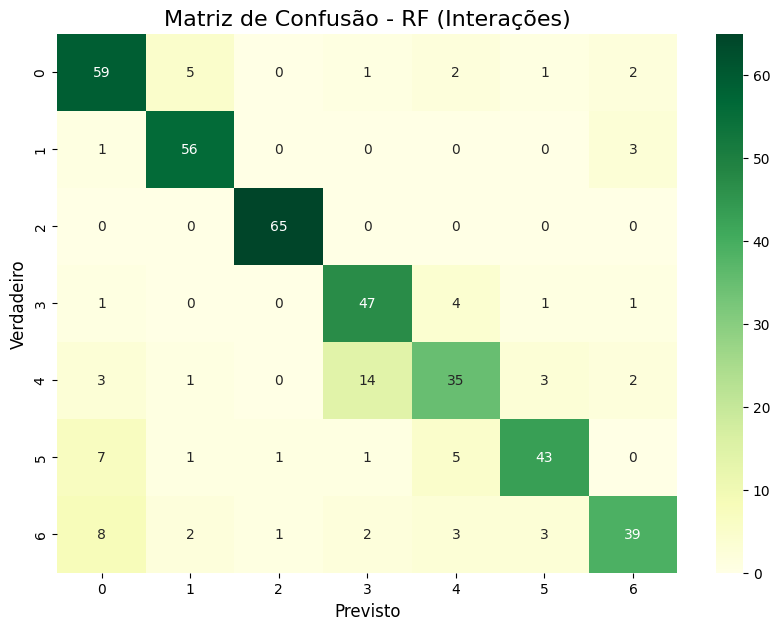

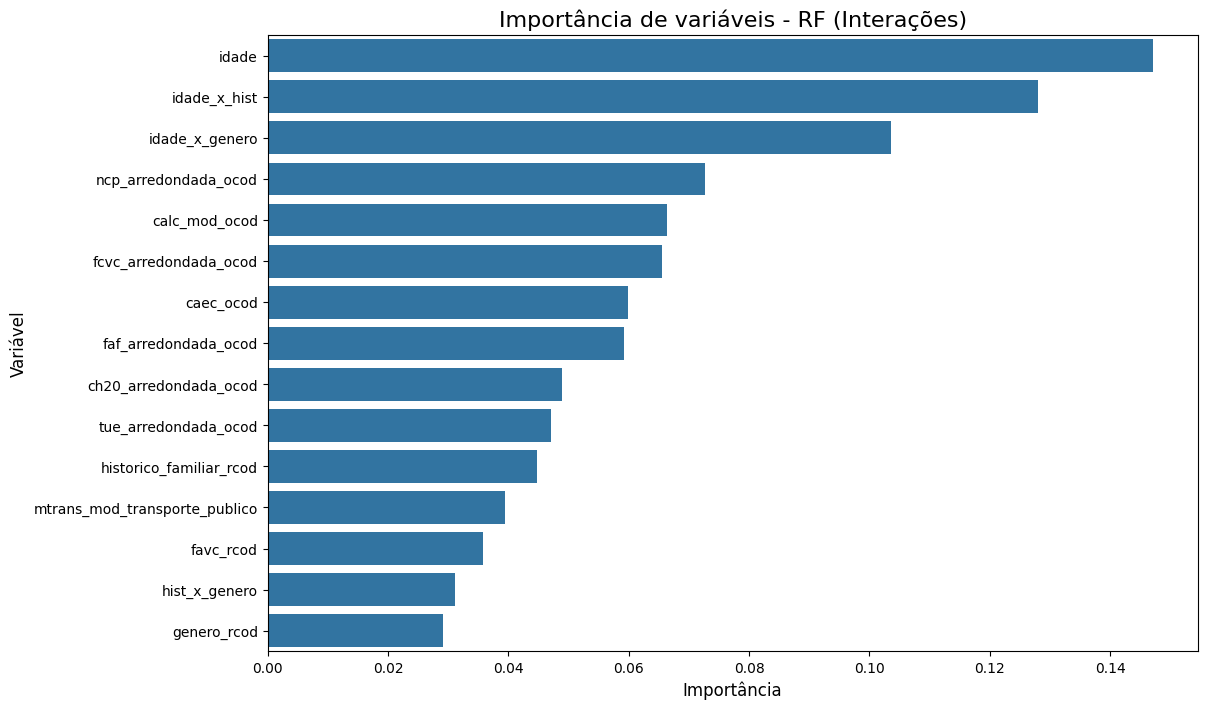

Capturando métricas do RF (Interações)...
Modelo RF (Interações) avaliado e salvo.


In [142]:
print("Criando e treinando o modelo Randm Forest (Otimizado) no dataset com interações...")

try:

    melhores_parametros_rf = rf_grid_search.best_params_
    print(f"Usando os parâmetros ótimos do RF: {melhores_parametros_rf}")

    modelo_rf_inter = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **melhores_parametros_rf
    )

    print("Treinando o novo modelo RF no dataset com interações...")
    modelo_rf_inter.fit(X_treino_inter, y_treino_inter)

except NameError:
    print("Erro: A variável 'rf_grid_search' não foi encontrada.")
    print("Por favor, re-execute rf_grid_search primeiro.")
    raise

y_previsao_rf_inter = modelo_rf_inter.predict(X_teste_inter)

print("\nRelatório de Classificação (RF com Interações):")
print(classification_report(y_teste_inter, y_previsao_rf_inter))

plotar_matriz_confusao(y_teste_inter, y_previsao_rf_inter,
                       "Matriz de Confusão - RF (Interações)",
                       cmap='YlGn')

plotar_importancia_variaveis(modelo_rf_inter, X_treino_inter.columns,
                          "Importância de variáveis - RF (Interações)")

print("Capturando métricas do RF (Interações)...")
metricas_todos_modelos['Otimizado (RF) - Interação'] = extrair_metricas_completas(y_teste_inter, y_previsao_rf_inter)

print("Modelo RF (Interações) avaliado e salvo.")

**Tabela compartiva**

In [143]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost  \
Geral    Acurácia                  0.8203        0.8298   0.8227   
Classe 0 precision                 0.8026        0.8378   0.7763   
         recall                    0.8714        0.8857   0.8429   
         f1-score                  0.8356        0.8611   0.8082   
Classe 1 precision                 0.8769        0.8906   0.8769   
         recall                    0.9500        0.9500   0.9500   
         f1-score                  0.9120        0.9194   0.9120   
Classe 2 precision                 0.9848        0.9848   0.9848   
         recall                    1.0000        1.0000   1.0000   
         f1-score                  0.9924        0.9924   0.9924   
Classe 3 precision                 0.7231        0.7164   0.8103   
         recall                    0.8704        0.8889   0.8704   
         f1-score                  0.7899        0.7934   0.8393   
Classe 4 precision                 0.6441        0.6607   0.6552   
         recall                    0.6552        0.6379   0.6552   
         f1-score                  0.6496        0.6491   0.6552   
Classe 5 precision                 0.8864        0.8696   0.7885   
         recall                    0.6724        0.6897   0.7069   
         f1-score                  0.7647        0.7692   0.7455   
Classe 6 precision                 0.8333        0.8400   0.8542   
         recall                    0.6897        0.7241   0.7069   
         f1-score                  0.7547        0.7778   0.7736   
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180   
         Weighted Avg (f1)         0.8184        0.8278   0.8209   

                            xgboost_otimizado    svm  regressao_logistica  \
Geral    Acurácia                      0.8251 0.7518               0.6052   
Classe 0 precision                     0.7792 0.6322               0.4712   
         recall                        0.8571 0.7857               0.7000   
         f1-score                      0.8163 0.7006               0.5632   
Classe 1 precision                     0.8730 0.7838               0.5532   
         recall                        0.9167 0.9667               0.8667   
         f1-score                      0.8943 0.8657               0.6753   
Classe 2 precision                     0.9848 0.9559               0.9028   
         recall                        1.0000 1.0000               1.0000   
         f1-score                      0.9924 0.9774               0.9489   
Classe 3 precision                     0.8070 0.7333               0.5833   
         recall                        0.8519 0.8148               0.6481   
         f1-score                      0.8288 0.7719               0.6140   
Classe 4 precision                     0.6500 0.6786               0.6136   
         recall                        0.6724 0.6552               0.4655   
         f1-score                      0.6610 0.6667               0.5294   
Classe 5 precision                     0.8600 0.7209               0.5526   
         recall                        0.7414 0.5345               0.3621   
         f1-score                      0.7963 0.6139               0.4375   
Classe 6 precision                     0.8200 0.7714               0.6364   
         recall                        0.7069 0.4655               0.1207   
         f1-score                      0.7593 0.5806               0.2029   
Médias   Macro Avg (f1)                0.8212 0.7396               0.5673   
         Weighted Avg (f1)             0.8242 0.7427               0.5736   

                            xgb_simplificado  rf_simplificado  xgb_interacao  \
Geral    Acurácia                     0.7872           0.8369         0.8156   
Classe 0 precision                    0.7273           0.8356         0.7922   
         recall                       0.8000           0.8714         0.8714   
         f1-score                     0.7619           0.8531         0.8299   
C


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1  \
                           Acurácia precision recall f1-score precision   
rf_simplificado              0.8369    0.8356 0.8714   0.8531    0.8906   
rf_otimizado                 0.8298    0.8378 0.8857   0.8611    0.8906   
xgboost_otimizado            0.8251    0.7792 0.8571   0.8163    0.8730   
xgboost                      0.8227    0.7763 0.8429   0.8082    0.8769   
rf_linha_base                0.8203    0.8026 0.8714   0.8356    0.8769   
xgb_interacao                0.8156    0.7922 0.8714   0.8299    0.8852   
Otimizado (RF) - Interação   0.8132    0.7468 0.8429   0.7919    0.8615   
xgb_simplificado             0.7872    0.7273 0.8000   0.7619    0.8475   
svm                          0.7518    0.6322 0.7857   0.7006    0.7838   
regressao_logistica          0.6052    0.4712 0.7000   0.5632    0.5532   

                                            Classe 2                  ...  \
                           recall f1-score precision recall f1-score  ...   
rf_simplificado            0.9500   0.9194    0.9848 1.0000   0.9924  ...   
rf_otimizado               0.9500   0.9194    0.9848 1.0000   0.9924  ...   
xgboost_otimizado          0.9167   0.8943    0.9848 1.0000   0.9924  ...   
xgboost                    0.9500   0.9120    0.9848 1.0000   0.9924  ...   
rf_linha_base              0.9500   0.9120    0.9848 1.0000   0.9924  ...   
xgb_interacao              0.9000   0.8926    0.9848 1.0000   0.9924  ...   
Otimizado (RF) - Interação 0.9333   0.8960    0.9701 1.0000   0.9848  ...   
xgb_simplificado           0.8333   0.8403    0.9701 1.0000   0.9848  ...   
svm                        0.9667   0.8657    0.9559 1.0000   0.9774  ...   
regressao_logistica        0.8667   0.6753    0.9028 1.0000   0.9489  ...   

                           Classe 4           Classe 5                  \
                             recall f1-score precision recall f1-score   
rf_simplificado              0.6897   0.6838    0.8723 0.7069   0.7810   
rf_otimizado                 0.6379   0.6491    0.8696 0.6897   0.7692   
xgboost_otimizado            0.6724   0.6610    0.8600 0.7414   0.7963   
xgboost                      0.6552   0.6552    0.7885 0.7069   0.7455   
rf_linha_base                0.6552   0.6496    0.8864 0.6724   0.7647   
xgb_interacao                0.6379   0.6435    0.8182 0.7759   0.7965   
Otimizado (RF) - Interação   0.6034   0.6542    0.8431 0.7414   0.7890   
xgb_simplificado             0.7414   0.7227    0.7647 0.6724   0.7156   
svm                          0.6552   0.6667    0.7209 0.5345   0.6139   
regressao_logistica          0.4655   0.5294    0.5526 0.3621   0.4375   

                            Classe 6                         Médias  \
                           precision recall f1-score Macro Avg (f1)   
rf_simplificado               0.8235 0.7241   0.7706         0.8315   
rf_otimizado                  0.8400 0.7241   0.7778         0.8232   
xgboost_otimizado             0.8200 0.7069   0.7593         0.8212   
xgboost                       0.8542 0.7069   0.7736         0.8180   
rf_linha_base                 0.8333 0.6897   0.7547         0.8141   
xgb_interacao                 0.7692 0.6897   0.7273         0.8102   
Otimizado (RF) - Interação    0.8298 0.6724   0.7429         0.8070   
xgb_simplificado              0.6667 0.6207   0.6429         0.7833   
svm                           0.7714 0.4655   0.5806         0.7396   
regressao_logistica           0.6364 0.1207   0.2029         0.5673   

                                              
                           Weighted Avg (f1)  
rf_simplificado                       0.8353  
rf_otimizado                          0.8278  
xgboost_otimizado                     0.8242  
xgboost                               0.8209  
rf_linha_base                         0.8184  
xgb_interacao                         0.8143  
Otimizado (RF) - Interação            0.8101  
xgb_simplificado                      0

## **Análise**

A criação das variaveis não surtiram o efeito esperado. O modelo XGBoost otimizado continua sendo o melhor modelo.

# **Análise final pós treinamento**

In [144]:
exibir_tabela_comparativa(metricas_todos_modelos)


--- Tabela Comparativa de Desempenho Completa ---
Visualização 1: Modelos nas Colunas


rf_linha_base  rf_otimizado  xgboost  \
Geral    Acurácia                  0.8203        0.8298   0.8227   
Classe 0 precision                 0.8026        0.8378   0.7763   
         recall                    0.8714        0.8857   0.8429   
         f1-score                  0.8356        0.8611   0.8082   
Classe 1 precision                 0.8769        0.8906   0.8769   
         recall                    0.9500        0.9500   0.9500   
         f1-score                  0.9120        0.9194   0.9120   
Classe 2 precision                 0.9848        0.9848   0.9848   
         recall                    1.0000        1.0000   1.0000   
         f1-score                  0.9924        0.9924   0.9924   
Classe 3 precision                 0.7231        0.7164   0.8103   
         recall                    0.8704        0.8889   0.8704   
         f1-score                  0.7899        0.7934   0.8393   
Classe 4 precision                 0.6441        0.6607   0.6552   
         recall                    0.6552        0.6379   0.6552   
         f1-score                  0.6496        0.6491   0.6552   
Classe 5 precision                 0.8864        0.8696   0.7885   
         recall                    0.6724        0.6897   0.7069   
         f1-score                  0.7647        0.7692   0.7455   
Classe 6 precision                 0.8333        0.8400   0.8542   
         recall                    0.6897        0.7241   0.7069   
         f1-score                  0.7547        0.7778   0.7736   
Médias   Macro Avg (f1)            0.8141        0.8232   0.8180   
         Weighted Avg (f1)         0.8184        0.8278   0.8209   

                            xgboost_otimizado    svm  regressao_logistica  \
Geral    Acurácia                      0.8251 0.7518               0.6052   
Classe 0 precision                     0.7792 0.6322               0.4712   
         recall                        0.8571 0.7857               0.7000   
         f1-score                      0.8163 0.7006               0.5632   
Classe 1 precision                     0.8730 0.7838               0.5532   
         recall                        0.9167 0.9667               0.8667   
         f1-score                      0.8943 0.8657               0.6753   
Classe 2 precision                     0.9848 0.9559               0.9028   
         recall                        1.0000 1.0000               1.0000   
         f1-score                      0.9924 0.9774               0.9489   
Classe 3 precision                     0.8070 0.7333               0.5833   
         recall                        0.8519 0.8148               0.6481   
         f1-score                      0.8288 0.7719               0.6140   
Classe 4 precision                     0.6500 0.6786               0.6136   
         recall                        0.6724 0.6552               0.4655   
         f1-score                      0.6610 0.6667               0.5294   
Classe 5 precision                     0.8600 0.7209               0.5526   
         recall                        0.7414 0.5345               0.3621   
         f1-score                      0.7963 0.6139               0.4375   
Classe 6 precision                     0.8200 0.7714               0.6364   
         recall                        0.7069 0.4655               0.1207   
         f1-score                      0.7593 0.5806               0.2029   
Médias   Macro Avg (f1)                0.8212 0.7396               0.5673   
         Weighted Avg (f1)             0.8242 0.7427               0.5736   

                            xgb_simplificado  rf_simplificado  xgb_interacao  \
Geral    Acurácia                     0.7872           0.8369         0.8156   
Classe 0 precision                    0.7273           0.8356         0.7922   
         recall                       0.8000           0.8714         0.8714   
         f1-score                     0.7619           0.8531         0.8299   
C


Visualização 2: Modelos nas Linhas (Transposto)


Geral  Classe 0                  Classe 1  \
                           Acurácia precision recall f1-score precision   
rf_simplificado              0.8369    0.8356 0.8714   0.8531    0.8906   
rf_otimizado                 0.8298    0.8378 0.8857   0.8611    0.8906   
xgboost_otimizado            0.8251    0.7792 0.8571   0.8163    0.8730   
xgboost                      0.8227    0.7763 0.8429   0.8082    0.8769   
rf_linha_base                0.8203    0.8026 0.8714   0.8356    0.8769   
xgb_interacao                0.8156    0.7922 0.8714   0.8299    0.8852   
Otimizado (RF) - Interação   0.8132    0.7468 0.8429   0.7919    0.8615   
xgb_simplificado             0.7872    0.7273 0.8000   0.7619    0.8475   
svm                          0.7518    0.6322 0.7857   0.7006    0.7838   
regressao_logistica          0.6052    0.4712 0.7000   0.5632    0.5532   

                                            Classe 2                  ...  \
                           recall f1-score precision recall f1-score  ...   
rf_simplificado            0.9500   0.9194    0.9848 1.0000   0.9924  ...   
rf_otimizado               0.9500   0.9194    0.9848 1.0000   0.9924  ...   
xgboost_otimizado          0.9167   0.8943    0.9848 1.0000   0.9924  ...   
xgboost                    0.9500   0.9120    0.9848 1.0000   0.9924  ...   
rf_linha_base              0.9500   0.9120    0.9848 1.0000   0.9924  ...   
xgb_interacao              0.9000   0.8926    0.9848 1.0000   0.9924  ...   
Otimizado (RF) - Interação 0.9333   0.8960    0.9701 1.0000   0.9848  ...   
xgb_simplificado           0.8333   0.8403    0.9701 1.0000   0.9848  ...   
svm                        0.9667   0.8657    0.9559 1.0000   0.9774  ...   
regressao_logistica        0.8667   0.6753    0.9028 1.0000   0.9489  ...   

                           Classe 4           Classe 5                  \
                             recall f1-score precision recall f1-score   
rf_simplificado              0.6897   0.6838    0.8723 0.7069   0.7810   
rf_otimizado                 0.6379   0.6491    0.8696 0.6897   0.7692   
xgboost_otimizado            0.6724   0.6610    0.8600 0.7414   0.7963   
xgboost                      0.6552   0.6552    0.7885 0.7069   0.7455   
rf_linha_base                0.6552   0.6496    0.8864 0.6724   0.7647   
xgb_interacao                0.6379   0.6435    0.8182 0.7759   0.7965   
Otimizado (RF) - Interação   0.6034   0.6542    0.8431 0.7414   0.7890   
xgb_simplificado             0.7414   0.7227    0.7647 0.6724   0.7156   
svm                          0.6552   0.6667    0.7209 0.5345   0.6139   
regressao_logistica          0.4655   0.5294    0.5526 0.3621   0.4375   

                            Classe 6                         Médias  \
                           precision recall f1-score Macro Avg (f1)   
rf_simplificado               0.8235 0.7241   0.7706         0.8315   
rf_otimizado                  0.8400 0.7241   0.7778         0.8232   
xgboost_otimizado             0.8200 0.7069   0.7593         0.8212   
xgboost                       0.8542 0.7069   0.7736         0.8180   
rf_linha_base                 0.8333 0.6897   0.7547         0.8141   
xgb_interacao                 0.7692 0.6897   0.7273         0.8102   
Otimizado (RF) - Interação    0.8298 0.6724   0.7429         0.8070   
xgb_simplificado              0.6667 0.6207   0.6429         0.7833   
svm                           0.7714 0.4655   0.5806         0.7396   
regressao_logistica           0.6364 0.1207   0.2029         0.5673   

                                              
                           Weighted Avg (f1)  
rf_simplificado                       0.8353  
rf_otimizado                          0.8278  
xgboost_otimizado                     0.8242  
xgboost                               0.8209  
rf_linha_base                         0.8184  
xgb_interacao                         0.8143  
Otimizado (RF) - Interação            0.8101  
xgb_simplificado                      0

Após o teste das 4 famílias de algoritmos o melhor modelo foi o XGBoost otimizado atingindo performance de 82.5% de acurácia.

**Resultados da engenharia de variaveis:**

**- Remover variaveis:** A performance piorou. As variaveis "fracas" scc, faf e tue não eram ruído e continham informação sutil.

**- Adicionar variaveis:** A performance piorou. O modelo já era inteligente o suficiente para encontrar essas interações sozinho.

**Conclusão:** O pico de performance que é possível extrair deste conjunto de dados ocorreu com o modelo treinado peli `XGBoost` otimizadao , treinado o arquivo completo obesidade_processado.csv original.

**Meta do projeto:**

Modelo com acurácia ≥ 75%:

O modelo  XGBoost otimizado teve 82.5% de acurácia, superando a meta.

**Ponto de atenção:**

f1-Score por classe:

A Classe 4 teve um F1-Score de 0.67.

A Classe 6 teve umF1-Score de 0.76

# **Salvando modelo final**

In [146]:
print("\n--- Salvando o Modelo escolhido ---")

nome_arquivo_modelo = "modelo_obesidade_final.joblib"

try:

    joblib.dump(modelo_simp_rf, nome_arquivo_modelo)

    print(f"\nSucesso! O modelo com melhor desmpenho no treinamento foi salvo em:")
    print(f"{os.path.abspath(nome_arquivo_modelo)}")

    print("\nTestando o carregamento do modelo salvo...")
    loaded_model = joblib.load(nome_arquivo_modelo)

    print("Modelo carregado com sucesso!")
    print("\nParâmetros do modelo carregado (verificação):")
    print(loaded_model.get_params())

except NameError:
    print(f"Erro: A variável 'xgb_melhor_modelo' não foi encontrada.")
    print("Por favor, certifique-se de que (XGBoost otimizado) foi executada.")
except Exception as e:
    print(f"Ocorreu um erro ao salvar o modelo: {e}")


--- Salvando o Modelo escolhido ---

Sucesso! O modelo com melhor desmpenho no treinamento foi salvo em:
/content/modelo_obesidade_final.joblib

Testando o carregamento do modelo salvo...
Modelo carregado com sucesso!

Parâmetros do modelo carregado (verificação):
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
